In [20]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import random
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from cycler import cycler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy

import pickle

from tqdm.auto import tqdm

path = Path(os.getcwd()).parent

In [2]:
def plot_auc_median(auc_score, std_aucs, drop, file_name,  save=False):
    aucs_upper = np.minimum(auc_score + std_aucs, 1)
    aucs_lower = np.maximum(auc_score - std_aucs, 0)
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score, color='blue', label='Median AUROC',  linestyle='-')
    plt.plot(len(auc_score)*drop*[0.5], color='black', linestyle='--', label='Chance')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

    
def plot_auc(auc_score, drop, file_name,  save=False):
    x_labels = range(0, (len(auc_score)*drop), drop)
    plt.plot(x_labels, auc_score, color='blue', linestyle='-', label='AUROC')
    plt.plot(len(auc_score)*drop*[0.5], color='black', linestyle='--', label='Chance')
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_rocs(rocs, file_name,  save=False):
    default_cycle = (cycler('linestyle',['-',':','-.', (0, (3, 5, 1, 5, 1, 5))]) +
                    cycler(color=['blue', 'orange', 'red', 'green']))
    plt.rc('')
    plt.rc('axes', prop_cycle=default_cycle)
    for fper, tper, std, deleted_elements in rocs:
        tpfrs_upper = np.minimum(tper + std, 1)
        tpfrs_lower = np.maximum(tper - std, 0)
        plt.plot(fper, tper, label=f'{int(deleted_elements)} samples removed')
        plt.fill_between(fper, tpfrs_lower, tpfrs_upper, alpha=0.2)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
   

def plot_class_ratio(ratios, representative_ratio, file_name,  save=False):
    plt.xlabel('Removed Examples')
    plt.ylabel('Ratio - >50K/<=50K')
    plt.plot(ratios, label='non-representative', linestyle='-', color='blue')
    plt.plot(len(ratios)*[representative_ratio], color='black', linestyle='--', label='representative')
    plt.ylim(0, 1.5)
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
  
    
def plot_experiment_comparison(auc_score_mrs, std_aucs_mrs, auc_score_experiment, std_aucs_experiment, 
                               experiment_label, drop, file_name,  save=False):
    aucs_upper = np.minimum(auc_score_mrs + std_aucs_mrs, 1)
    aucs_lower = np.maximum(auc_score_mrs - std_aucs_mrs, 0)
    
    aucs_upper_experiment = np.minimum(auc_score_experiment + std_aucs_experiment, 1)
    aucs_lower_experiment = np.maximum(auc_score_experiment - std_aucs_experiment, 0)
    
    x_labels = range(0, (len(auc_score_mrs)*drop), drop)
    
    plt.fill_between(x_labels, aucs_lower, aucs_upper, color='orange', alpha=0.2)
    plt.plot(x_labels, auc_score_mrs, color='orange', linestyle='-', label='MRS')
    
    plt.fill_between(x_labels, aucs_lower_experiment, aucs_upper_experiment, color='blue', alpha=0.2)
    plt.plot(x_labels, auc_score_experiment, linestyle=':', color='blue', label=experiment_label)
    
    plt.plot(len(auc_score_mrs)*drop*[0.5], color='black', linestyle='--', label='Chance')
    
    plt.ylabel('AUROC')
    plt.xlabel('Number of removed observations')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_c(c_values, file_name, save=False):
    plt.xlabel('Iteration')
    plt.ylabel('SVM C Value')
    plt.yscale('log')
    plt.plot(c_values)
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()
    
def plot_probability_divergences(kl_values, file_name, save=False):
    plt.xlabel('Iteration')
    plt.ylabel('Divergence')
    plt.plot(kl_values, label= "Kullback Leibler", color='black', linestyle='-')
    plt.legend()
    if save:
        plt.savefig(f'{file_name}.pdf')
    plt.show()

In [3]:
def stacked_histograms(representative_probabilities, nonrepresentative_propabilities, chosen_samples,
                       directory, iteration, save_figure=False, temperature=0):
    n_bins = 200
    labels = ['Representative', 'Nonrepresentative']
    vax = plt.axes()
    plt.xlabel('Probability of being non-representative')
    plt.ylabel('Number of elements')
    colors = ['blue', 'red']
    #for i, value in enumerate(chosen_samples):
     #   chosen_samples[i] = float("{:.2f}".format(chosen_samples[i]))
    plt.hist((representative_probabilities, nonrepresentative_propabilities), n_bins,
             histtype='bar', stacked=True, label=labels, color=colors)
    plt.vlines(chosen_samples, 0, 1, transform=vax.get_xaxis_transform(), 
               colors='black', linestyles='dashed')
    plt.legend()
    if save_figure:
        os.makedirs(f'{directory}/histograms/', exist_ok=True)
        plt.savefig(f'{directory}/histograms/histogram_temperature_{temperature}_iteration_{iteration}.pdf')
    plt.show()

# MRS Algorithm

To allow statistical inference in social sciences, survey participants must be selected at random
from the target population. When samples are drawn from parts of the population that are
close to hand, subgroups might be over-represented. This leads to statistical analyses under
sampling bias, which in turn may produce similarly biased outcomes. This notebook uses machine learning to reduce this selection bias in a psychological survey (**GBS**) using auxiliary information (**GESIS**/**Allensbach**) from comparable studies that are known to be representative. The proposed algorithm is first tested on US national Census data.

In [4]:
def grid_search(X_train, y_train, cv=5):
    clf = DecisionTreeClassifier()
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities
    param_grid = {'ccp_alpha': ccp_alphas}
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

In [5]:
def temperature_sample(softmax: list,
                       temperature: float,
                       drop: int):
    EPSILON = 10e-16 # to avoid taking the log of zero
    softmax = (np.array(softmax)).astype('float64')
    softmax[softmax == 0] = EPSILON
    preds = np.log(softmax) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    count = 0
    while np.isnan(preds).any() and count < 100:
        preds = [0 if x != x else x for x in preds]
        preds = exp_preds / np.sum(exp_preds)
        count += 1
        
    if count == 100:
        return []
        
    if len(preds[preds != 0]) < drop:
        drop = len(preds[preds != 0]) 
    probas = np.random.choice(len(preds), drop, replace=False, p=preds)
    return probas

In [6]:
def MRS(N: pd.DataFrame, 
        columns,
        R: pd.DataFrame,
        number_of_splits = 5,
        temperature: float=0.5,
        n_drop: int=1,
        cv=5):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """
    preds = []
    bootstrap_iterations = 5
    
    kf = KFold(n_splits=number_of_splits)
    for train_index, test_index in kf.split(N):
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        n = min(len(R), len(N_train))
        bootstrap_predictions = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R.sample(n=n, replace=True)], sort=True)
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
        preds.extend(np.mean(bootstrap_predictions, axis=0))
        
    drop_ids = temperature_sample(preds, temperature, n_drop)
    return N.drop(N.index[drop_ids])

In [7]:
def cv_bootstrap_prediction(N, R, number_of_splits, columns, cv):
    preds = np.zeros(len(N))
    preds_r = np.zeros(len(R))
    bootstrap_iterations = 5
    
    kf = KFold(n_splits=number_of_splits, shuffle=True)
    for split_n, split_r in zip(kf.split(N), kf.split(R)):
        train_index, test_index = split_n
        train_index_r, test_index_r  = split_r
        N_train, N_test = N.iloc[train_index], N.iloc[test_index]
        R_train, R_test = R.iloc[train_index_r], R.iloc[test_index_r]
        n = min(len(R_train), len(N_train))
        r = len(R_train)
        bootstrap_predictions = []
        bootstrap_predictions_r = []
        for j in range(bootstrap_iterations):
            bootstrap = pd.concat([N_train.sample(n=n, replace=True),
                                      R_train.sample(n=r, replace=True)])
            clf = grid_search(bootstrap[columns], bootstrap.label, cv)
            bootstrap_predictions.append(clf.predict_proba(N_test[columns])[:,1])
            bootstrap_predictions_r.append(clf.predict_proba(R_test[columns])[:,1])
        preds[test_index]  = np.mean(bootstrap_predictions, axis=0)
        preds_r[test_index_r] = np.mean(bootstrap_predictions_r, axis=0)
    return preds, preds_r

In [8]:
def auc_prediction(N, R, columns, test_size, cv=5):
    number_of_trees = 3
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    all_train = pd.concat([X_train, y_train], axis=1)
    
    bootstrap_predictions = []
    for _ in range(number_of_trees):
        bootstrap = all_train.sample(n=len(all_train), replace=True)
        clf = grid_search(bootstrap[columns], bootstrap.label, cv)
        bootstrap_predictions.append(clf.predict_proba(X_test)[:,1])
                           
    y_predict = np.mean(bootstrap_predictions, axis=0)
    return y_test, y_predict

In [9]:
def auc_prediction(N, R, columns, test_size, cv=5):
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)

    clf = grid_search(X_train[columns], y_train, cv)
    y_predict = clf.predict_proba(X_test)[:,1]
    return y_test, y_predict

In [10]:
def kullback_leibler_divergence(preds, preds_r):
    q, _ = np.histogram(preds, bins=100, range=(0, 1), density=True)
    p, _ = np.histogram(preds_r, bins=100, range=(0, 1), density=True)   
    EPSILON  = 10e-16
    q = q + EPSILON
    p = p + EPSILON    
    return entropy(q, p)

In [11]:
def MRS_with_histogram(N, R, columns, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5, directory='', iteration=0, grid_search=None, temperature_sampling=True):
    """
    MRS Algorithm
    
    Input:
        * N: dataset that is assumed to not be representative.
        * R: dataset that is known to be representative.
        * temperature: temperature value for probabilistic sampling procedure.
        * drop: number of instances to drop per iteration (small values result in long runtimes).
        * number_of_splits: splits per iteration.
    
    Output:
        * N/Drop: N without the dropped elements
    """ 
    
    preds, preds_r = cv_bootstrap_prediction(N, R, number_of_splits, columns, cv)
    all_preds = np.concatenate([preds, preds_r])
    all_true = np.concatenate([np.ones(len(preds)), np.zeros(len(preds_r))])
    auc = roc_auc_score(all_true, all_preds)
    
    kl_value = kullback_leibler_divergence(preds, preds_r)
    
    if temperature_sampling:
        #temperature = 0.4 ** (2 * kl_value - 2)
        temperature = 0.1 ** ((auc-0.5)*8)
        print("auc", auc)
        print("temperature", temperature)
    else:
        temperature = 1
    temperature = 0.01
    drop_ids = temperature_sample(preds, temperature, n_drop)
    
    if iteration % 10 == 0:
        stacked_histograms(preds_r, preds, np.array(preds)[drop_ids], directory, iteration, True, temperature)
        print(f'Divergence : {kl_value}')
        print(f'Temperature: {temperature}')
    
    return N.drop(N.index[drop_ids]), kl_value

In [12]:
def calculate_median_roc(y_test, y_predict, iteration, drop):
    interpolation_points = 250
    median_fpr = np.linspace(0, 1, interpolation_points)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_predict)
    interp_tpr = np.interp(median_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    return (median_fpr, interp_tpr, [(iteration+1)*drop]*interpolation_points)

In [13]:
def repeated_MRS(df, columns, number_of_splits, n_drop=1,test_size=0.33, cv=5, us=False, directory='', 
                 us_bias='', temperature_sampling=True):
    
    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    number_of_iterations = int(len(N) / drop)
    aucs = []
    roc = []
    ratio = []
    kl_values = []
    # auroc_iteration = int(int(len(N) / n_drop) / 3.5)
    auroc_iteration = 150
    
    if us:
        representative_ratio = (len(R[R[us_bias] == 1]) /
                                len(R[R[us_bias] == 0]))
    #start value
    y_true, y_preds = auc_prediction(N, R, columns, test_size)
    roc.append(calculate_median_roc(y_true, y_preds, -1, drop))
    aucs.append(roc_auc_score(y_true, y_preds))
    
    for i in tqdm(range(number_of_iterations)):
        N, kl_value = MRS_with_histogram(N, R, columns,
                                number_of_splits=number_of_splits,
                               n_drop=n_drop, cv=cv, directory=directory, iteration=i, grid_search=grid_search,
                                                                     temperature_sampling=temperature_sampling)
        
        kl_values.append(kl_value)
        y_true, y_preds = auc_prediction(N, R, columns, test_size)
        aucs.append(roc_auc_score(y_true, y_preds))
        print(roc_auc_score(y_true, y_preds))
        
        # calculate auroc
        if((i+1) % auroc_iteration == 0):
            roc.append(calculate_median_roc(y_true, y_preds, i, drop))
        
        # only for US Census experiment
        if us:
            ratio.extend([len(N[N[us_bias] == 1]) / 
                         (len(N[N[us_bias] == 0]))]*drop)
            if ((i+1) % 10 == 0):
                plot_class_ratio(ratio, representative_ratio, directory + '/tmp_ratio', save=False)
                 
        if ((i+1) % 10 == 0):
            plot_probability_divergences(kl_values, directory + '/divergence', True)
            
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
          
    plot_probability_divergences(kl_values,  directory + '/divergence', True)
    
    if us:
        return ratio, aucs, roc
    else:
        return N, aucs, roc

## Experiment 1
### <font color='darkblue'>US National Census (Income)</font>  <a name="us"></a>

*About this Dataset*

**US Adult Census** (1994) relates income to social factors: 

- *age*: continuous.
- *workclass*: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- *fnlwgt*: continuous.
- *education*: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- *education-num*: continuous.
- *marital-status*: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- *occupation*: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- *relationship*: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- *race*: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- *sex*: Female, Male.
- *capital-gain*: continuous.
- *capital-loss*: continuous.
- *hours-per-week*: continuous.
- *native-country*: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Each row is labelled as either having a salary greater than ">50K" or "<=50K".

Note: This Dataset was obtained from the UCI repository, it can be found on

https://archive.ics.uci.edu/ml/datasets/census+income, http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [17]:
columns = ['age', 'c_charge_degree', 'race', 'score_text', 'sex', 'priors_count', 
         'is_violent_recid', 'decile_score', 'is_recid']

df = pd.read_csv(os.path.join(path, 'data/compas/compas-scores.csv'))
df = df[columns]
# df['c_charge_degree'] = df[df['c_charge_degree'] != '0']
# df = df[(df['days_b_screening_arrest'] <= 30.0) & (df['days_b_screening_arrest'] >= -30.0)]

df['sex'].replace('Male', 0, inplace=True)
df['sex'].replace('Female', 1, inplace=True)

#df['age'] = df.astype({'age': 'int32'}).dtypes

us_bias = 'age'
#positive_elements_bias = ['Caucasian']
#df[us_bias].mask(~df[us_bias].isin(positive_elements_bias), 0, inplace=True)
#df[us_bias].mask(df[us_bias].isin(positive_elements_bias), 1, inplace=True)

df.loc[(df.age <= 30),'age'] = 1
df.loc[(df.age > 30),'age'] = 0

df = df.replace('-1',np.NaN)
df.dropna(inplace=True)
#df.reset_index(inplace=True, drop=True)

ctg = [
    'score_text',
    'c_charge_degree',
    'race'
      ]
for c in ctg:
    df = pd.concat([df, pd.get_dummies(df[c], 
                                       prefix=c,
                                       dummy_na=False)], axis=1).drop([c],axis=1)
    
df_high = df[(df[us_bias] == 1)].copy(deep=True)
df_low = df[(df[us_bias] == 0)].copy(deep=True)

high_normal = len(df_high)
low_normal = len(df_low)

rep_fraction = 0.3
bias_fraction = 0.5

#-----------------Simulate non-representative data---------------------#
rep = pd.concat([df_low.head(int(low_normal * rep_fraction)),
                df_high.head(int(high_normal * rep_fraction))],
                ignore_index=True) 

nonrep_more_low = pd.concat([df_low.tail(int(low_normal * (rep_fraction + bias_fraction))), 
                             df_high.tail(int(high_normal * rep_fraction))],
                            ignore_index=True)

nonrep_more_high = pd.concat([df_low.tail(int(low_normal * rep_fraction)),
                             df_high.tail(int(high_normal * (rep_fraction + bias_fraction))),], 
                             ignore_index=True)


#-----------------Simulate representative data---------------------#
rep2 = pd.concat([df_low.tail(int(low_normal * rep_fraction)),
                 df_high.tail(int(high_normal * rep_fraction))], 
                 ignore_index=True) 

rep['label'] = 0
nonrep_more_low['label'] = 1
nonrep_more_high['label'] = 1
rep2['label'] = 1

print("Current setting:")

print('Rep: \n', rep[us_bias].value_counts())
print('Rep 2: \n', rep2[us_bias].value_counts())
print('Nonrep_more_high: \n', nonrep_more_high[us_bias].value_counts())
print('nonrep_more_low: \n', nonrep_more_low[us_bias].value_counts())

us_nonrep_more_low = pd.concat([rep.copy(deep=True), nonrep_more_low.copy(deep=True)])
us_nonrep_more_high = pd.concat([rep.copy(deep=True), nonrep_more_high.copy(deep=True)])
us_rep = pd.concat([rep.copy(deep=True), rep2.copy(deep=True)])

us_columns = list(us_rep.columns)
meta = ['label', 'index', us_bias]
for m in meta:
    if m in us_columns:
        us_columns.remove(m)

Current setting:
Rep: 
 0    1923
1    1598
Name: age, dtype: int64
Rep 2: 
 0    1923
1    1598
Name: age, dtype: int64
Nonrep_more_high: 
 1    4263
0    1923
Name: age, dtype: int64
nonrep_more_low: 
 0    5130
1    1598
Name: age, dtype: int64


In [18]:
us_nonrep_more_high

,age,sex,priors_count,is_violent_recid,decile_score,is_recid,score_text_High,score_text_Low,score_text_Medium,c_charge_degree_F,c_charge_degree_M,c_charge_degree_O,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,label
0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,5,-1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,0,0,0,1,3,1,0,1,0,1,0,0,1,0,0,0,0,0,0
3,0,0,2,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6181,1,0,1,0,4,1,0,1,0,1,0,0,1,0,0,0,0,0,1
6182,1,0,0,0,3,0,0,1,0,1,0,0,0,0,1,0,0,0,1
6183,1,0,0,0,7,0,0,0,1,1,0,0,0,0,1,0,0,0,1
6184,1,0,3,0,7,1,0,0,1,0,1,0,0,0,1,0,0,0,1


## Experiment 1 a)


### Simulate non-representative data. More low than in R

| income      | Representative (R) | Non-Representative (N) |
|-------------|--------------------|------------------------|
| low (<=50K) | 3715               | ????                   |
| high (>50K) | 1168               | ????                   |

In [ ]:
drop = 80
number_of_splits = 5
test_size = 0.3
cv = 3
representative_ratio = (len(us_rep[us_rep[us_bias] == 1]) / len(us_rep[us_rep[us_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_nonrep_more_low',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)



ratio, auc, roc = repeated_MRS(us_nonrep_more_low, us_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = cv, us = True, directory=result_dir, us_bias=us_bias)
    

file_name = os.path.join(result_dir,  str(temp) + '_ratio_more_low' + us_bias)
plot_class_ratio(ratio, representative_ratio, file_name, save=True)   
plot_auc(auc, drop, file_name + '_auc', save=True)

  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
pickle.dump(ratio, open("results/ratio_more_low", 'wb'))
pickle.dump(representative_ratio, open("results/representative_ratio_more_low", 'wb'))

### Load saved results

In [14]:
ratio = pickle.load(open("results/ratio_more_low", 'rb'))
representative_ratio = pickle.load(open("results/representative_ratio_more_low", 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'results/ratio_more_low'

### Visualise results

In [ ]:
plot_class_ratio(ratio, representative_ratio, '', save=False)

## Experiment 1 b)


### Simulate non-representative data. More high than in R

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| low (<=50K) | 3715               | ????                   |
| high (>50K) | 1168               | ???                    |


auc 0.47102929945796934
temperature 1.705161837547118


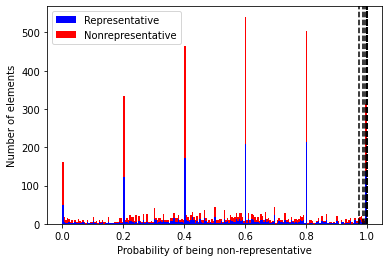

Divergence : 0.0498433132010678
Temperature: 0.01
0.5068399006483119
auc 0.4626070846442515
temperature 1.9913303955773283
0.4947349251748776
auc 0.463480718405772
temperature 1.9595405397079722
0.504910237113627
auc 0.4422320867379007
temperature 2.898299794904782
0.5
auc 0.43547832436433476
temperature 3.2822632114680323
0.5146520892752049
auc 0.4311290815702581
temperature 3.556045813258004
0.5
auc 0.43014811891060933
temperature 3.620887642579195
0.5
auc 0.41102526899940695
temperature 5.1498887579328585
0.5
auc 0.4117674509041415
temperature 5.079961171318362
0.5
auc 0.4220129183016622
temperature 4.206265225418904
0.49930651872399445


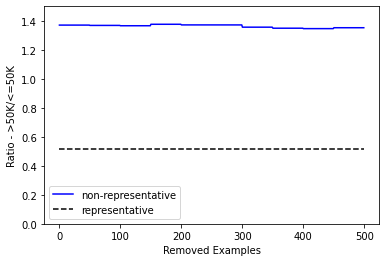

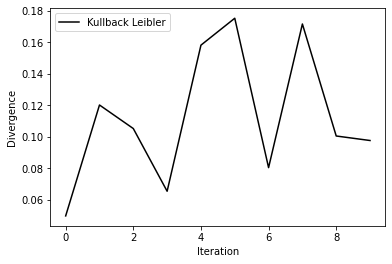

auc 0.40245606139028284
temperature 6.030474826309993


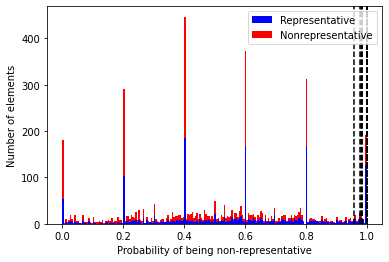

Divergence : 0.18176110319499683
Temperature: 0.01
0.5
auc 0.4071241266776981
temperature 5.533590111364083
0.5035657944485731
auc 0.4034471787165097
temperature 5.921375061289962
0.5
auc 0.38225997311698906
temperature 8.748230453189738
0.5
auc 0.3899504136288877
temperature 7.592707874930716
0.504763897023959
auc 0.37101728122174216
temperature 10.761225949830314
0.5
auc 0.3802858281687968
temperature 9.072215851247282
0.5
auc 0.3741041041041041
temperature 10.166399391836832
0.5
auc 0.3772071172071172
temperature 9.601587904911893
0.5
auc 0.3732508584404076
temperature 10.327450747758663
0.510293305564759


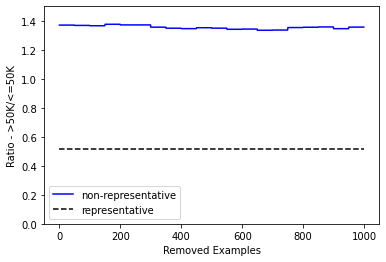

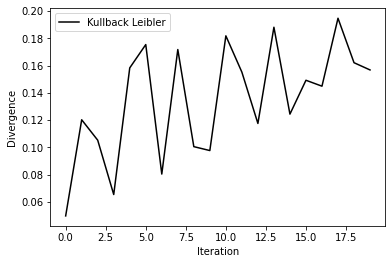

auc 0.3392382129763833
temperature 19.323878411786996


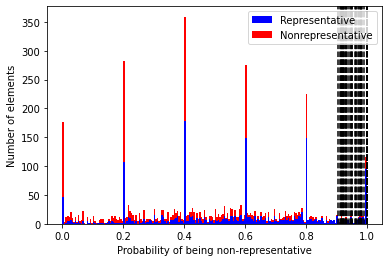

Divergence : 0.25937786663100654
Temperature: 0.01
0.4919421219780932
auc 0.3511404763294612
temperature 15.519445115238643
0.5033688031839603
auc 0.3394768575456699
temperature 19.239117172261178
0.47407597711780225
auc 0.33712637294829073
temperature 20.09042002003894
0.5
auc 0.3303066344840728
temperature 22.779643553118586
0.5
auc 0.3122817551207382
temperature 31.750162985781085
0.5
auc 0.31248658771130683
temperature 31.630590400385664
0.5007365734833545
auc 0.2976471510169964
temperature 41.57409382729476
0.4932382493358103
auc 0.3053400870910858
temperature 36.08106127800519
0.49582610133068855
auc 0.29984997394088303
temperature 39.92088940696796
0.5


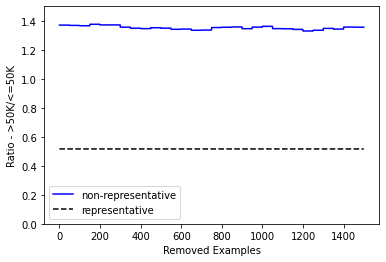

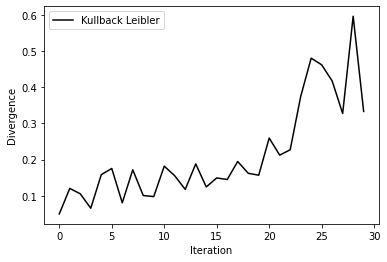

auc 0.30843775301692566
temperature 34.07987364209939


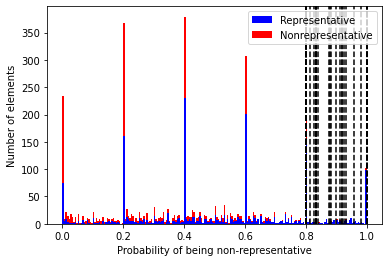

Divergence : 0.4749785401425187
Temperature: 0.01
0.507342564239116
auc 0.2939307132576363
temperature 44.519911663847026
0.5
auc 0.28020592020592017
temperature 57.32613186770735
0.5
auc 0.28471850444693897
temperature 52.7535832871635
0.5
auc 0.27829855645995416
temperature 59.37608357809186
0.5
auc 0.27961500563063063
temperature 57.9535380858981
0.5
auc 0.26315102761563747
temperature 78.48592464495161
0.5
auc 0.24803951289692736
temperature 103.67735208937762
0.49146688216455664
auc 0.26016669363974754
temperature 82.92136658768382
0.5
auc 0.253058426073132
temperature 94.52193232965871
0.5


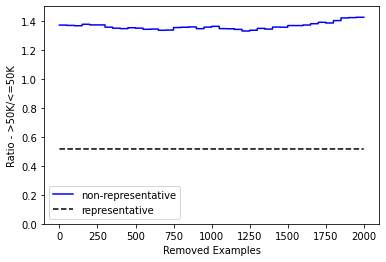

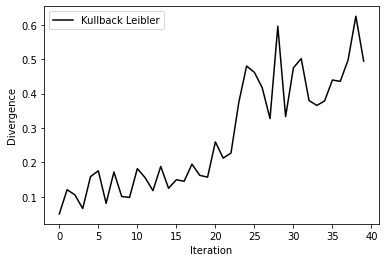

auc 0.2521498771498772
temperature 96.11717166286205


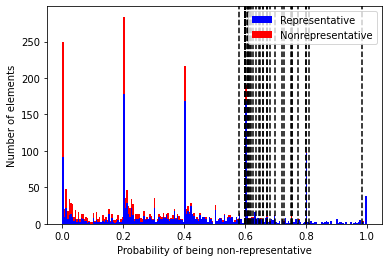

Divergence : 0.6841624304572399
Temperature: 0.01
0.5
auc 0.2560309605380028
temperature 89.4854271906688
0.5
auc 0.25656702837500844
temperature 88.60613091077954
0.4803515905285816
auc 0.26334603220241515
temperature 78.20449976039954
0.4973186456598779
auc 0.2709078309078309
temperature 68.03577758622683
0.5
auc 0.2633414856574366
temperature 78.21104969699944
0.5
auc 0.2858561551584807
temperature 51.65956664882885
0.4972972972972973
auc 0.3651645123384253
temperature 11.986265722173572
0.48859256607600976
auc 0.3797480348874771
temperature 9.16253656722484
0.4959326974032856
auc 0.4016078689308778
temperature 6.125436591537022
0.5


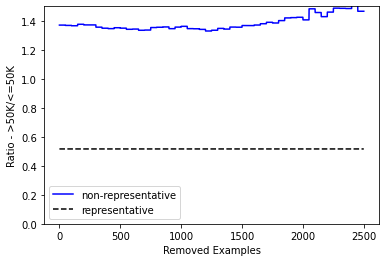

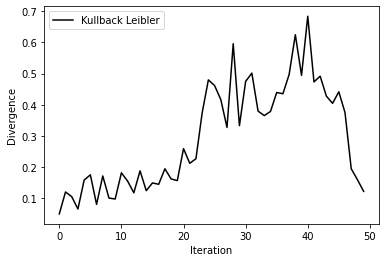

auc 0.4131618932365201
temperature 4.951135979696173


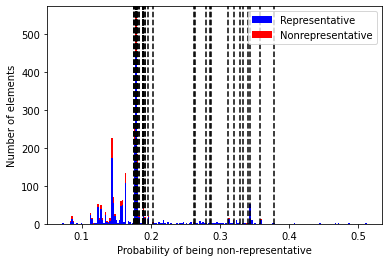

Divergence : 0.10618203211776453
Temperature: 0.01
0.4525157232704402
auc 0.3913943488943489
temperature 7.393417120622445
0.5
auc 0.38570431358510826
temperature 8.2104222215618
0.5
auc 0.40508794508794504
temperature 5.745084745043748
0.5
auc 0.39037730800107034
temperature 7.533235355397783
0.5
auc 0.4810793029871978
temperature 1.416986054545992
0.41572217378668985
auc 0.4670217276099629
temperature 1.835803439156279
0.6376126126126127



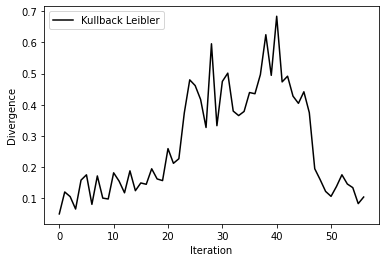

NameError: name 'temp' is not defined

In [16]:
drop = 50
number_of_splits = 5
test_size = 0.3
representative_ratio = (len(us_rep[us_rep[us_bias] == 1]) / len(us_rep[us_rep[us_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_nonrep_more_high',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)

ratio, auc, roc = repeated_MRS(us_nonrep_more_high, us_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = 3, us = True, directory=result_dir, us_bias=us_bias)
    

file_name = os.path.join(result_dir) + '_ratio_more_high' + us_bias
plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
plot_auc(auc, drop, file_name + '_auc', save=True)

## Experiment 1 c)


### Simulate already representative data

| income      | Representative (R) | Representative (N)     |
|-------------|--------------------|------------------------|
| low (<=50K) | 3715               | 3715                   |
| high (>50K) | 1168               | 1168                   |

*Here we run the MRS algorithm to test whether the ratio low-high is still maintained.*

In [ ]:
drop = 100
number_of_splits = 5
test_size = 0.3
representative_ratio = (len(us_rep[us_rep[us_bias] == 1]) / len(us_rep[us_rep[us_bias] == 0]))
result_dir = os.path.join(os.getcwd(), 'results/compas_rep',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir, exist_ok=True)

ratio, auc, roc = repeated_MRS(us_rep, us_columns,
                    number_of_splits = number_of_splits, n_drop = drop,
                           test_size = test_size, cv = 3, us = True, directory=result_dir, us_bias=us_bias)
    
file_name = os.path.join(result_dir) + '_ratio_rep'  + us_bias
plot_class_ratio(ratio, representative_ratio, file_name, save=True) 
plot_auc(auc, drop, file_name + '_auc', save=True)

## Experiment 2
### <font color='darkgreen'>Allensbach</font>   <---MRS---> <font color='darkred'>GBS</font> <---MRS---> <font color='darkgreen'>GESIS</font> 

*Figure shows MRS concept on GBS and GESIS for experiment 2 a). Replace Allensbach with GESIS for experiment 2 b)*

<img src="overview.PNG" width="450" height="450"/>


**Multivariate auxiliary information GESIS linked to GBS so that expected selection bias can be detected and corrected for. In addition, GBS contains an attribute for positive and negative treatment of survey participents for further analysis (Experiment 4).**


## Experiment 2 a)
### <font color='darkgreen'>Allensbach Studie - Institut für Demoskopie(IfD)</font>  <a name="us"></a>

### <font color='darkred'>Important note:</font>  <a name="allensbach"></a> Allensbach is already merged with GBS in this data set


In [55]:
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Berufsgruppe', 'Erwerbstaetigkeit', 'Geschlecht',
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']

scaler = StandardScaler()
scaled_allensbach = allensbach.copy(deep=True)
scaled_allensbach[allensbach_columns] = scaler.fit_transform(scaled_allensbach[allensbach_columns])

drop = 20
number_of_splits = 5
result_dir_allensbach = os.path.join(os.getcwd(), 'results/gbs_allensbach', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(result_dir_allensbach, exist_ok=True)

test_size = 0.3
number_of_iterations = int((len(scaled_allensbach[scaled_allensbach['label']  == 1]) -
                           number_of_splits)/drop)

aucs = []
rocs = []

for _ in tqdm(range(2)):
    allensbach_mrs, auc, roc = repeated_MRS(scaled_allensbach, allensbach_columns,
                     number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=3, directory=result_dir_allensbach)
    aucs.append(auc)
    rocs.append(roc)
    
    median_rocs = []
    for i in range(len(rocs[0])):
        median_tpr = np.median(np.array(rocs)[:, i, 0], axis = 0)
        median_fpr = np.median(np.array(rocs)[:, i, 1], axis = 0)
        std_tpr = np.std(np.array(rocs)[:, i, 1], axis = 0)
        removed_samples = np.array(rocs)[:, i, 2][0][0]
        median_rocs.append([median_tpr, median_fpr, std_tpr, removed_samples])
    
    
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False)
    plot_rocs(median_rocs, '', save=False)
    
plot_auc_median(median_aucs, std_aucs, drop, result_dir_allensbach + "/median_aucs" , save=True)
plot_rocs(median_rocs, result_dir_allensbach + "/median_rocs", save=True)
    
pickle.dump(median_aucs, open(result_dir_allensbach + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_allensbach + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_allensbach + "/median_rocs", 'wb'))

KeyboardInterrupt: 

In [ ]:
pickle.dump(median_aucs, open("results/allensbach_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/allensbach_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/allensbach_median_rocs", 'wb'))

### Load saved results

In [ ]:
allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))
allensbach_rocs = pickle.load(open("results/allensbach_median_rocs", "rb"))

### Visualise results

In [ ]:
file_name = result_dir_allensbach + '/auc'
plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, drop, file_name, save=True)

file_name = result_dir_allensbach + '/roc'
plot_rocs(allensbach_rocs, file_name, save=True)

### Experiment 2 b)
### <font color='darkgreen'>Gesis</font>  <a name="us"></a>

In [56]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

    
'''Geschlecht', 'Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe',
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Nettoeinkommen Haushalt', 'Schlechter Schlaf', 'Leben genießen',
       'Zu Nichts aufraffen', 'Alles anstrengend', 'Wahlteilnahme',
       'Wahlabsicht', 'Desinteresse Politiker', 'Zufriedenheit Leben', 'Aktiv',
       'Verärgert', 'Wach', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'leicht Vertrauen', 'Faulheit', 'Entspannt',
       'wenig kuenstlerisches Interesse', 'Druck', 'Optimismus Zukunft',
       'Zufriedenheit Wahlergebnis', 'Resilienz'''

N = gbs.copy()
R = gesis.copy()

N['label'] = 1
R['label'] = 0

gesis_gbs = pd.concat([N, R], ignore_index=True)

In [57]:
scaler = StandardScaler()
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_gesis_gbs[gesis_columns] = scaler.fit_transform(scaled_gesis_gbs[gesis_columns])

auc 0.8604074676109912
temperature 0.00130839916746747


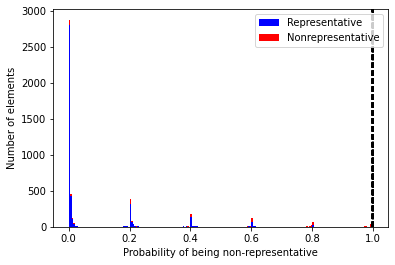

Divergence : 1.9221326051085794
Temperature: 0.00130839916746747
0.7579154995331466
auc 0.8575800851384163
temperature 0.0013783493916229052
0.7785403050108932
auc 0.8530674684559633
temperature 0.0014978221625806976




KeyboardInterrupt: 

In [65]:
drop = 20
number_of_splits = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/gbs_gesis',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.3

os.makedirs(result_dir_gesis, exist_ok=True)
aucs = []
rocs = []

for temp in tqdm(range(2)):
    gbs_mrs, auc, roc = repeated_MRS(scaled_gesis_gbs, gesis_columns, number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=5, directory=result_dir_gesis)
    aucs.append(auc)
    rocs.append(roc)
    
    median_rocs = []
    for i in range(len(rocs[0])):
        median_tpr = np.median(np.array(rocs)[:, i, 0], axis = 0)
        median_fpr = np.median(np.array(rocs)[:, i, 1], axis = 0)
        std_tpr = np.std(np.array(rocs)[:, i, 1], axis = 0)
        removed_samples = np.array(rocs)[:, i, 2][0][0]
        median_rocs.append([median_tpr, median_fpr, std_tpr, removed_samples])
    
    
    median_aucs = np.median(aucs, axis = 0)
    std_aucs = np.std(aucs, axis = 0)
    plot_auc_median(median_aucs, std_aucs, drop, '', save=False)
    plot_rocs(median_rocs, '', save=False)

plot_auc_median(median_aucs, std_aucs, drop, result_dir_gesis + "/median_aucs" , save=True)
plot_rocs(median_rocs, result_dir_gesis + "/median_rocs", save=True)

pickle.dump(median_aucs, open(result_dir_gesis + "/median_aucs", 'wb'))
pickle.dump(std_aucs, open(result_dir_gesis + "/std_aucs", 'wb'))
pickle.dump(median_rocs, open(result_dir_gesis + "/median_rocs", 'wb'))

In [ ]:
pickle.dump(median_aucs, open("results/gesis_median_aucs", 'wb'))
pickle.dump(std_aucs, open("results/gesis_std_aucs", 'wb'))
pickle.dump(median_rocs, open("results/gesis_median_rocs", 'wb'))

### Load saved results

In [ ]:
gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))
gesis_median_rocs =  pickle.load(open("results/gesis_median_rocs", 'rb'))

### Visualise results

In [ ]:
file_name = result_dir_gesis + '/auc'
plot_auc_median(gesis_median_aucs, gesis_std_aucs, drop, file_name, save=False)

file_name = result_dir_gesis + '/roc'
plot_rocs(gesis_median_rocs, file_name, save=False)

### Experiment 2 c)
### <font color='darkgreen'> Comparison with a third independent dataset (Allensbach) </font>

In [318]:
def repeated_MRS_with_third_dataset(df, columns, temperature, comparing_dataset, comparing_dataset_columns,
                                    number_of_splits, number_of_iterations,
                                    n_drop=1, test_size=0.33, cv=5):

    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    C = comparing_dataset.copy()
    auc = []
    comparison_auc = []

    #start value
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[columns])[:,1]
    auc.append(roc_auc_score(y_test, y_predict))
    
    # start value checking
    data = pd.concat([N, C])
    X_train, X_test, y_train, y_test = train_test_split(data[comparing_dataset_columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[comparing_dataset_columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[comparing_dataset_columns])[:,1]
    comparison_auc.append(roc_auc_score(y_test, y_predict))
    
    for i in tqdm(range(number_of_iterations)):
        N = MRS(N, R, columns, number_of_splits=number_of_splits, temperature=temperature, n_drop=n_drop, cv=cv)
        
        # auc gesis
        data = pd.concat([N, R])
        X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[columns])[:,1]
        auc.append(roc_auc_score(y_test, y_predict))
        
        # auc allensbach
        data = pd.concat([N, C])
        X_train, X_test, y_train, y_test = train_test_split(data[comparing_dataset_columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf = grid_search(X_train[comparing_dataset_columns], y_train, cv)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[comparing_dataset_columns])[:,1]
        comparison_auc.append(roc_auc_score(y_test, y_predict))
           
        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break
    return N, auc, comparison_auc

In [22]:
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), engine='python')
gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), engine='python')

gesis_columns = ['Geburtsjahr', 'Geburtsland',
       'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Berufliche Ausbildung',  
       'Personen im Haushalt', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll']

gbs_scaling_columns = ['Geburtsjahr', 'Geburtsland', 'Nationalitaet', 'Familienstand', 'Hoechster Bildungsabschluss',
       'Personen im Haushalt', 'Berufliche Ausbildung', 'Erwerbstaetigkeit', 'Berufsgruppe', 'Nettoeinkommen Selbst',
       'Zufriedenheit Wahlergebnis', 'Resilienz', 'Gesellig', 'Andere kritisieren',
       'Gruendlich', 'Nervoes', 'Phantasievoll', 'Alter', 'Geschlecht', 'BRS1', 'BRS2', 'BRS3',
                      'BRS4', 'BRS5', 'BRS6','woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus', 'Schulabschluss']


all_columns = ['Erwerbstaetigkeit', 'Geschlecht']

allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_columns = ['Alter', 'BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6', 
                      'Optimismus', 'Pessimismus', 'Schulabschluss', 'woechentlicheArbeitszeit']
           

gbs['label'] = 1
gesis['label'] = 0
gesis_gbs = pd.concat([gbs, gesis])

In [328]:
# calculate with allensbach
scaled_allensbach_gbs = allensbach.copy(deep=True)
scaled_gesis_checking = gesis.copy(deep=True)

all_scaler = StandardScaler()
all_scaler = all_scaler.fit(pd.concat([scaled_allensbach_gbs[all_columns], scaled_gesis_checking[all_columns]]))


scaler_allensbach = StandardScaler()
scaled_allensbach_gbs[allensbach_columns] = scaler_allensbach.fit_transform(scaled_allensbach_gbs[allensbach_columns])
scaled_allensbach_gbs[all_columns] = all_scaler.transform(scaled_allensbach_gbs[all_columns])
scaled_gesis_checking[all_columns] = all_scaler.transform(scaled_gesis_checking[all_columns])


# calculate with gesis
scaled_gesis_gbs = gesis_gbs.copy(deep=True)
scaled_allensbach_checking = allensbach[allensbach['label']==0].copy(deep=True)

all_scaler = StandardScaler()
scaler_gesis = StandardScaler()
all_scaler = all_scaler.fit(pd.concat([scaled_gesis_gbs[all_columns], scaled_allensbach_checking[all_columns]]))
scaled_gesis_gbs[all_columns] = all_scaler.transform(scaled_gesis_gbs[all_columns])
scaled_gesis_gbs[gesis_columns] = scaler_gesis.fit_transform(scaled_gesis_gbs[gesis_columns])

scaled_allensbach_checking[all_columns] = all_scaler.transform(scaled_allensbach_checking[all_columns])

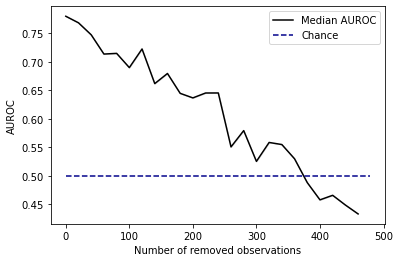

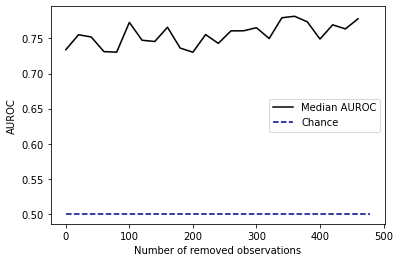

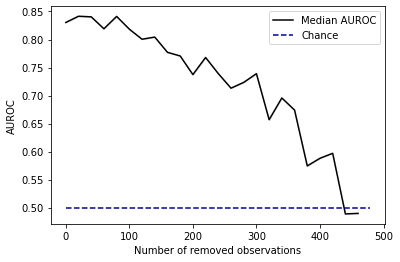

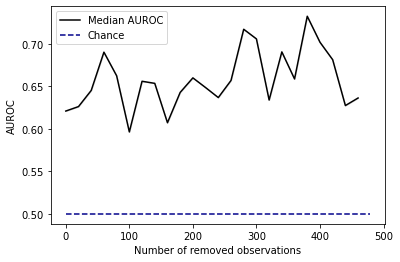

In [332]:
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 1)

drop = 20
number_of_splits = 5
result_dir_gesis = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_gesis_allensbach_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
result_dir_allensbach = os.path.join(os.getcwd(), 'results/third_dataset_test/gbs_allensbach_gesis_check', 
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))


cv = 5
test_size = 0.3
number_of_iterations = int(len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) / drop - number_of_splits)

aucs_gesis = []
aucs_gesis_checking = []
aucs_allensbach = []
aucs_allensbach_checking = []


#calculate mrs with allensbach
for temp in tqdm(temperatures):
    _, auc_allensbach, auc_gesis_checking = repeated_MRS_with_third_dataset(scaled_allensbach_gbs, 
                      allensbach_columns, temp, comparing_dataset=scaled_gesis_checking, 
                      comparing_dataset_columns=all_columns, 
                      number_of_iterations=number_of_iterations, 
                      number_of_splits=number_of_splits, n_drop=drop, test_size=test_size, cv=cv)
    
    
    # allensbach
    aucs_allensbach.append(auc_allensbach)
    allensbach_median_aucs = np.median(aucs_allensbach, axis = 0)
    allensbach_std_aucs = np.std(aucs_allensbach, axis = 0)
    plot_auc_median(allensbach_median_aucs, allensbach_std_aucs, drop, '', save=False)
    
    # gesis checking
    aucs_gesis_checking.append(auc_gesis_checking)
    gesis_median_comparison_aucs = np.median(aucs_gesis_checking, axis = 0)
    gesis_std_comparison_aucs = np.std(aucs_gesis_checking, axis = 0)
    plot_auc_median(gesis_median_comparison_aucs, gesis_std_comparison_aucs, drop, '', save=False)
    
# calculate mrs with gesis
for temp in tqdm(temperatures):
    _, auc_gesis, auc_allensbach_checking = repeated_MRS_with_third_dataset(scaled_gesis_gbs, gesis_columns, temp,
                            comparing_dataset=scaled_allensbach_checking, 
                            comparing_dataset_columns=all_columns,
                            number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                            n_drop=drop, test_size=test_size, cv=cv)
    
    # gesis
    aucs_gesis.append(auc_gesis)
    gesis_median_aucs = np.median(aucs_gesis, axis = 0)
    gesis_std_aucs = np.std(aucs_gesis, axis = 0)
    plot_auc_median(gesis_median_aucs, gesis_std_aucs, drop, '', save=False) 
    
    # allensbach checking
    aucs_allensbach_checking.append(auc_allensbach_checking)
    allensbach_median_comparison_aucs = np.median(aucs_allensbach_checking, axis = 0)
    allenbach_std_comparison_aucs = np.std(aucs_allensbach_checking, axis = 0)
    plot_auc_median(allensbach_median_comparison_aucs, allenbach_std_comparison_aucs, drop, '', save=False)
     
os.makedirs(result_dir_gesis, exist_ok=True)
os.makedirs(result_dir_allensbach, exist_ok=True)

pickle.dump(allensbach_median_aucs, open(result_dir + "/allensbach_median_aucs", 'wb'))
pickle.dump(allensbach_std_aucs, open(result_dir + "/allensbach_std_aucs", 'wb'))
pickle.dump(allensbach_median_comparison_aucs, open(result_dir + "/allensbach_median_comparison_aucs", 'wb'))
pickle.dump(allenbach_std_comparison_aucs, open(result_dir + "/allenbach_std_comparison_aucs", 'wb'))

pickle.dump(gesis_median_aucs, open(result_dir + "/gesis_median_aucs", 'wb'))
pickle.dump(gesis_std_aucs, open(result_dir + "/gesis_std_aucs", 'wb'))
pickle.dump(gesis_median_comparison_aucs, open(result_dir + "/gesis_median_comparison_aucs", 'wb'))
pickle.dump(gesis_std_comparison_aucs, open(result_dir + "/gesis_std_comparison_aucs", 'wb'))

In [35]:
pickle.dump(allensbach_median_comparison_aucs, open("results/allensbach_median_comparison_aucs", 'wb'))
pickle.dump(allenbach_std_comparison_aucs, open("results/allenbach_std_comparison_aucs", 'wb'))

pickle.dump(gesis_median_comparison_aucs, open("results/gesis_median_comparison_aucs", 'wb'))
pickle.dump(gesis_std_comparison_aucs, open("results/gesis_std_comparison_aucs", 'wb'))

### Load saved results

In [99]:
allensbach_median_comparison_aucs = pickle.load(open("results/allensbach_median_comparison_aucs", 'rb'))
allenbach_std_comparison_aucs = pickle.load(open("results/allenbach_std_comparison_aucs", 'rb'))

gesis_median_comparison_aucs = pickle.load(open("results/gesis_median_comparison_aucs", 'rb'))
gesis_std_comparison_aucs = pickle.load(open("results/gesis_std_comparison_aucs", 'rb'))

allensbach_median_aucs = pickle.load(open("results/allensbach_median_aucs", "rb"))
allensbach_std_aucs = pickle.load(open("results/allensbach_std_aucs", "rb"))

gesis_median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
gesis_std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))

### Visualise results

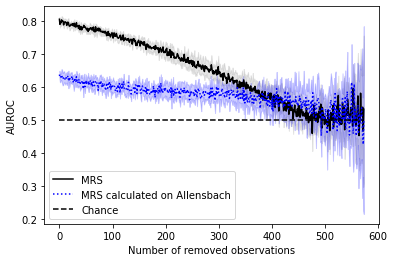

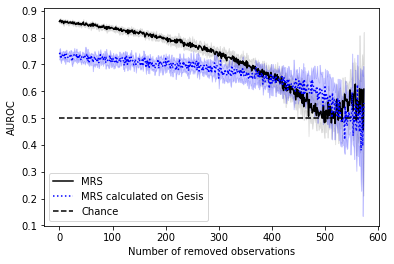

In [101]:
experiment_label = 'MRS calculated on Allensbach'
file_name = result_dir_allensbach + '/calculated_allensbach'
plot_experiment_comparison(allensbach_median_aucs, allensbach_std_aucs, gesis_median_comparison_aucs,
                      gesis_std_comparison_aucs, experiment_label, drop, file_name, save=True)

experiment_label = 'MRS calculated on Gesis'
file_name = result_dir_gesis + '/calculated_gesis'
plot_experiment_comparison(gesis_median_aucs, gesis_std_aucs, allensbach_median_comparison_aucs, 
                      allenbach_std_comparison_aucs, experiment_label, drop, file_name, save=True)

# Compare MRS with temperature sampling and without 

### Run experiment

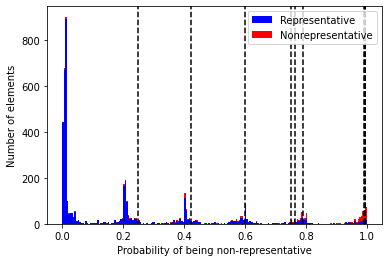

Divergence : 1.8973583517452155
Temperature: 1


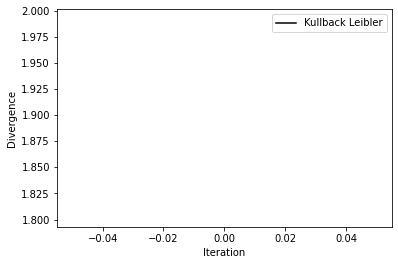

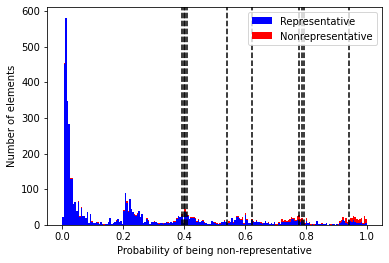

Divergence : 1.8879182888517188
Temperature: 1


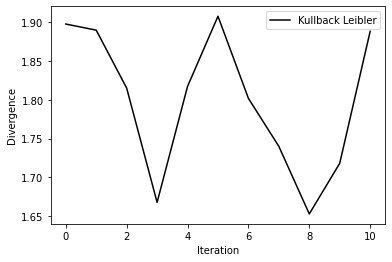

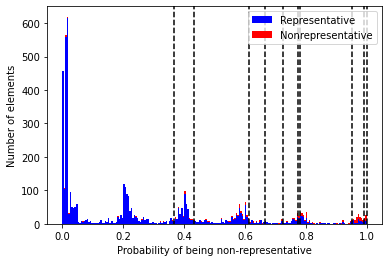

Divergence : 1.7746426457841107
Temperature: 1


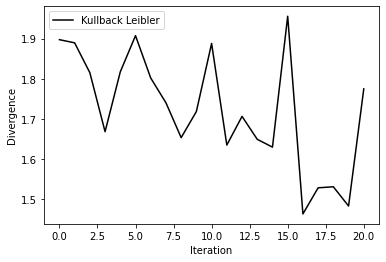

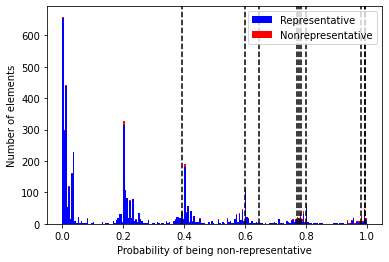

Divergence : 1.5700696917540486
Temperature: 1


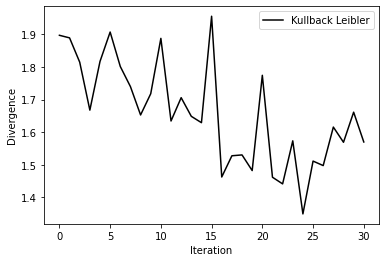

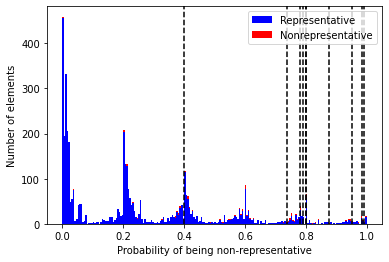

Divergence : 1.481353353265668
Temperature: 1


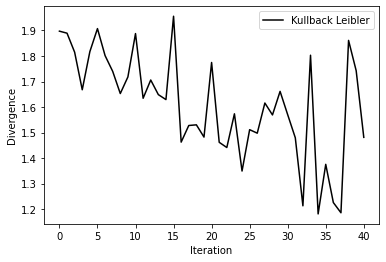

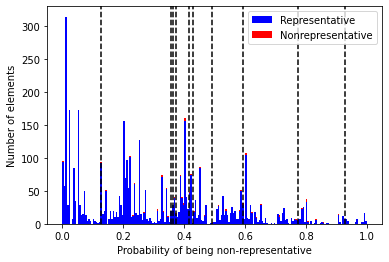

Divergence : 1.1283339574105822
Temperature: 1


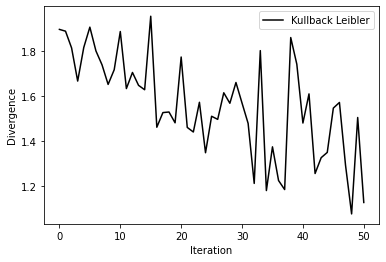

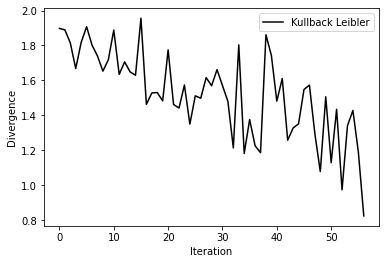

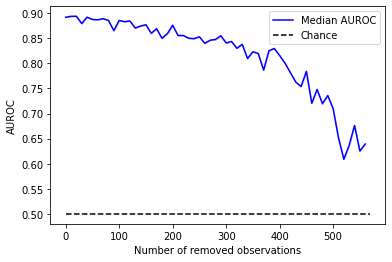

In [127]:
drop = 10
number_of_splits = 5
result_dir_temperature = os.path.join(os.getcwd(), 'results/temperature_comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

cv= 5
test_size = 0.3
number_of_iterations = int((len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) -
                           number_of_splits)/drop)
#number_of_iterations = 50

aucs_without_temperature = [] 
    
for _ in tqdm(range(1)):
    _, auc_without_temperature, _ = repeated_MRS(scaled_gesis_gbs, gesis_columns,
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=cv, directory=result_dir_temperature,
                                                 temperature_sampling=False)
    
    aucs_without_temperature.append(auc_without_temperature)
    median_aucs_without_temperature = np.median(aucs_without_temperature, axis = 0)
    std_aucs_without_temperature = np.std(aucs_without_temperature, axis = 0)
    plot_auc_median(median_aucs_without_temperature, std_aucs_without_temperature, drop, '', save=True)
    
os.makedirs(result_dir_temperature, exist_ok=True)
pickle.dump(median_aucs_without_temperature, open(result_dir_temperature + "/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs_without_temperature, open(result_dir_temperature + "/std_aucs_without_temperature", 'wb'))

In [ ]:
pickle.dump(median_aucs_without_temperature, open("results/median_aucs_without_temperature", 'wb'))
pickle.dump(std_aucs_without_temperature, open("results/std_aucs_without_temperature", 'wb'))

### Load saved results

In [97]:
median_aucs_without_temperature = pickle.load(open("results/median_aucs_without_temperature", 'rb'))
std_aucs_without_temperature = pickle.load(open("results/std_aucs_without_temperature", 'rb'))

median_aucs_temperature = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_temperature = pickle.load(open("results/gesis_std_aucs", 'rb'))

### Visualise results

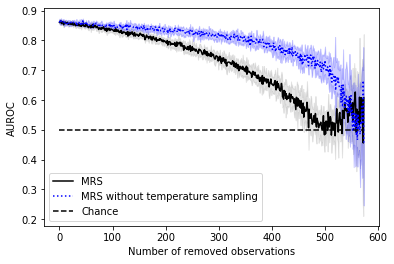

In [98]:
experiment_label = 'MRS without temperature sampling'   
file_name = result_dir_temperature + '/temperature_comparison'
plot_experiment_comparison(median_aucs_temperature, std_aucs_temperature, median_aucs_without_temperature, 
                                std_aucs_without_temperature, experiment_label, 
                           drop, file_name, save=True)   

# Compare MRS with cross-validation and without

In [8]:
def MRS_without_cv(N: pd.DataFrame, R: pd.DataFrame, columns: list, number_of_splits = 5, temperature: float=0.5,
        n_drop: int=1, cv=5):
    
    preds = []
    bootstrap_iterations = 20
    kf = KFold(n_splits=number_of_splits)
    bootstrap_predictions = np.zeros(len(N))
    counter = np.zeros(len(N))
    n = min(len(R), len(N))
    for _ in range(bootstrap_iterations):
        n_sample = N.sample(n=n, replace=True)
        N_test = N.drop(n_sample.index)
        
        while len(N_test) == 1:
            n_sample = N.sample(n=n, replace=True)
            N_test = N.drop(n_sample.index)
        
        bootstrap = pd.concat([n_sample,
                                  R.sample(n=n, replace=True)])
        
        locations_not_in_bootstrap = list(set([N.index.get_loc(index) for index in N_test.index]))
        clf = grid_search(bootstrap[columns], bootstrap.label, 5)
        clf.fit(bootstrap[columns], bootstrap.label)
        proba = clf.predict_proba(N_test[columns])[:,1]
        bootstrap_single = np.zeros(len(N))
        bootstrap_single[list(locations_not_in_bootstrap)] = proba
        counter[list(locations_not_in_bootstrap)] += 1
        bootstrap_predictions += bootstrap_single
    with np.errstate(divide='ignore'):
        preds = bootstrap_predictions / counter
    preds = [0 if x != x else x for x in preds]
    drop_ids = temperature_sample(preds, 1, n_drop)
    return N.drop(N.index[drop_ids])

def repeated_MRS_without_cv(df, columns, temperature, number_of_splits, number_of_iterations,
                 n_drop=1,test_size=0.33, cv=5, us=False):

    N = df[df['label'] == 1].copy()
    R = df[df['label'] == 0].copy()
    auc = []
    
    #start value
    data = pd.concat([N, R])
    X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
    clf = grid_search(X_train[columns], y_train, cv)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_test[columns])[:,1]
    auc.append(roc_auc_score(y_test, y_predict))
    
 
    for i in tqdm(range(number_of_iterations)):
        N = MRS_without_cv(N, R, columns, number_of_splits=number_of_splits, temperature=temperature, n_drop=n_drop, cv=cv)
        
        data = pd.concat([N, R])
        X_train, X_test, y_train, y_test = train_test_split(data[columns], data.label,
                                                                test_size=test_size, stratify=data.label)
        clf.fit(X_train, y_train)
        y_predict = clf.predict_proba(X_test[columns])[:,1]
        auc.append(roc_auc_score(y_test, y_predict))

        if len(N)-drop <= cv or len(N)-drop <= number_of_splits:
            break  

    return auc 

In [ ]:
mu, sigma = 0.1, 0.06
temperatures = np.random.normal(mu, sigma, 10)

drop = 1
number_of_splits = 5
result_dir_cv = os.path.join(os.getcwd(), 'results/cv__comparison',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.5
number_of_iterations = int((len(scaled_gesis_gbs[scaled_gesis_gbs['label']  == 1]) -
                           number_of_splits)/drop)
#number_of_iterations = 50

aucs_with_cv = []
aucs_without_cv = [] 
    
for temp in tqdm(temperatures):
    auc_without_cv = repeated_MRS_without_cv(scaled_gesis_gbs, gesis_columns, temp, 
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                    n_drop=drop, test_size=test_size, cv=3, grid_search=grid_search_tree)
    
    aucs_without_cv.append(auc_without_cv)
    median_aucs_without_cv = np.median(aucs_without_cv, axis = 0)
    std_aucs_without_cv = np.std(aucs_without_cv, axis = 0)
    plot_auc_median(median_aucs_without_cv, std_aucs_without_cv, drop, '', save=False)
    
plot_auc_cv_comparison(median_aucs_cv, std_aucs_cv, median_aucs_without_cv, 
                                std_aucs_without_cv, drop, '', save=False)   
os.makedirs(result_dir_cv, exist_ok=True)
pickle.dump(median_aucs_without_cv, open(result_dir_cv + "/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs_without_cv, open(result_dir_cv + "/std_aucs_without_cv", 'wb'))

In [ ]:
pickle.dump(median_aucs_without_cv, open("results/median_aucs_without_cv", 'wb'))
pickle.dump(std_aucs_without_cv, open("results/std_aucs_without_cv", 'wb'))

### Load saved results

In [45]:
median_aucs_cv = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs_cv = pickle.load(open("results/gesis_std_aucs", 'rb'))

median_aucs_without_cv = pickle.load(open("results/median_aucs_without_cv", 'rb'))
std_aucs_without_cv = pickle.load(open("results/std_aucs_without_cv", 'rb'))

### Visualise results

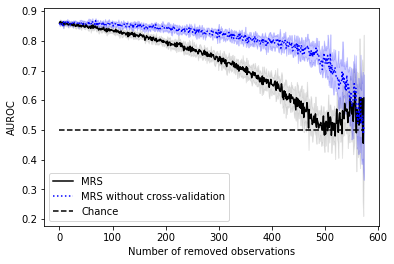

In [95]:
experiment_label = 'MRS without cross-validation'
file_name = result_dir_cv + '/cross_validation_comparison'
 
plot_experiment_comparison(median_aucs_cv, std_aucs_cv, median_aucs_without_cv, 
                                std_aucs_without_cv, experiment_label, drop, 
                           file_name, save=True)    

# Random drops

### Run experiment

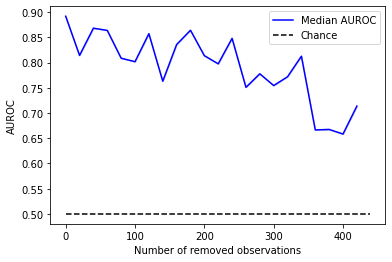

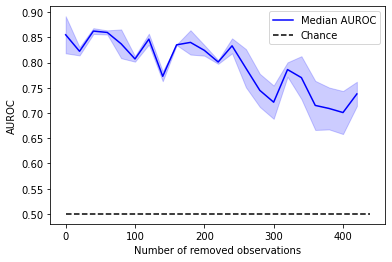

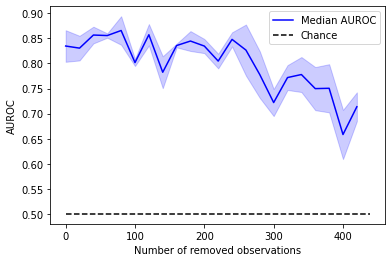

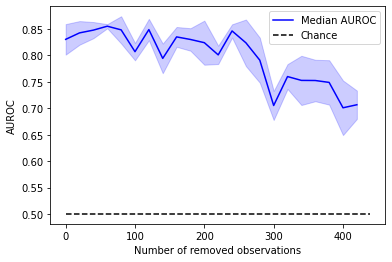

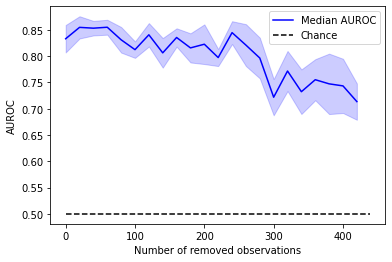

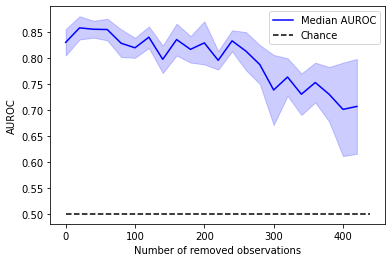

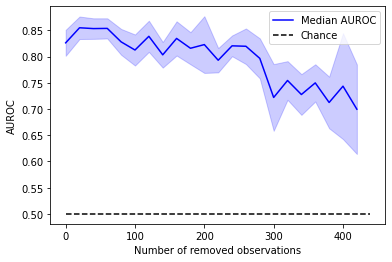

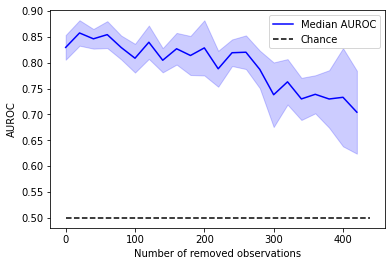

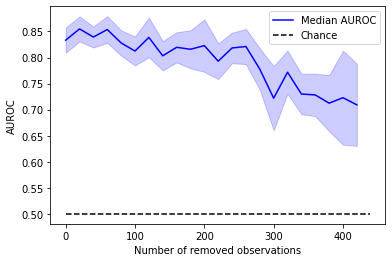

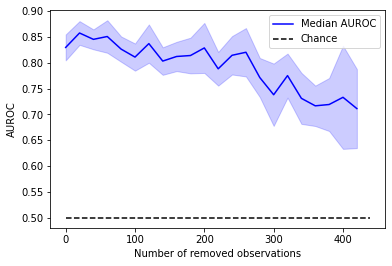

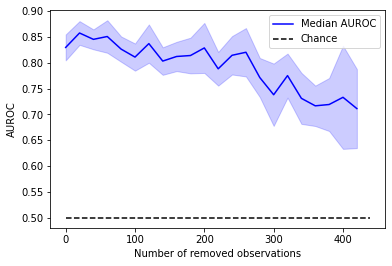

In [241]:
drop = 20
result_dir = os.path.join(os.getcwd(), 'results/random_drop',  
                          datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

cv = 5
test_size = 0.3
number_of_splits = 5
aucs_random_drop = []

for _ in tqdm(range(10)):
    
    N = scaled_gesis_gbs[scaled_gesis_gbs['label'] == 1].copy()
    R = scaled_gesis_gbs[scaled_gesis_gbs['label'] == 0].copy()
    iterations = int(len(N)/drop) - cv - 1
    aucs = []   
    for _ in tqdm(range(iterations)):
        
        random_int = random.sample(range(0, len(N)), drop)
        N.drop(N.index[random_int], inplace=True)
    
        y_true, y_preds = auc_prediction(N, R, gesis_columns, test_size)
        aucs.append(roc_auc_score(y_true, y_preds))
        
    aucs_random_drop.append(aucs)
    median_aucs_random_drop = np.median(aucs_random_drop, axis = 0)
    std_aucs_random_drop = np.std(aucs_random_drop, axis = 0)
    plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, '', save=False)
    

os.makedirs(result_dir, exist_ok=True)
plot_auc_median(median_aucs_random_drop, std_aucs_random_drop, drop, '', save=False)


pickle.dump(median_aucs_random_drop, open(result_dir + "/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open(result_dir + "/std_aucs_random_drop", 'wb'))

In [42]:
pickle.dump(median_aucs_random_drop, open("results/median_aucs_random_drop", 'wb'))
pickle.dump(std_aucs_random_drop, open("results/std_aucs_random_drop", 'wb'))

### Load saved results

In [75]:
median_aucs_random_drop = pickle.load(open("results/median_aucs_random_drop", 'rb'))
std_aucs_random_drop = pickle.load(open("results/std_aucs_random_drop", 'rb'))

median_aucs = pickle.load(open("results/gesis_median_aucs", 'rb'))
std_aucs = pickle.load(open("results/gesis_std_aucs", 'rb'))

### Visualise results

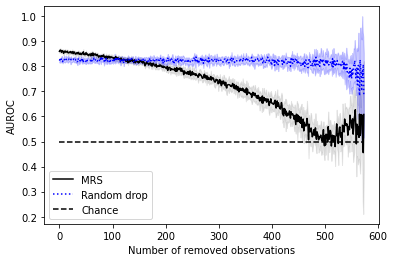

In [93]:
experiment_label = 'Random drop'
file_name = result_dir + '/random_drop_experiment'
plot_experiment_comparison(median_aucs, std_aucs, median_aucs_random_drop, 
                                std_aucs_random_drop, experiment_label, drop, file_name,  True)

# Calculate AUROC between Gesis and Allensbach

In [325]:
columns = ['Erwerbstaetigkeit', 'Geschlecht']
allensbach = pd.read_csv(os.path.join(path, 'data/allensbach_mrs.csv'))
allensbach.drop(['Unnamed: 0'], axis=1, inplace=True)
allensbach_copy = allensbach.copy(deep=True)
gesis_copy = gesis.copy(deep=True) 
gesis_copy['label'] = 1
allensbach_gesis = pd.concat([allensbach_copy, gesis_copy])

scaler = StandardScaler()
scaled_allensbach_gesis = allensbach_gesis.copy(deep=True)
scaled_allensbach_gesis[columns] = scaler.fit_transform(scaled_allensbach_gesis[columns])

X_train, X_test, y_train, y_test = train_test_split(scaled_allensbach_gesis[columns], scaled_allensbach_gesis.label,
                                                         test_size=0.3, stratify=scaled_allensbach_gesis.label)
clf = grid_search(X_train[columns], y_train, 5)
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test[columns])[:,1]
print(roc_auc_score(y_test, y_predict))

0.584382822677137


## Generate MRS

Divergence : 1.5919444819273825
Temperature: 0.1487637528731426


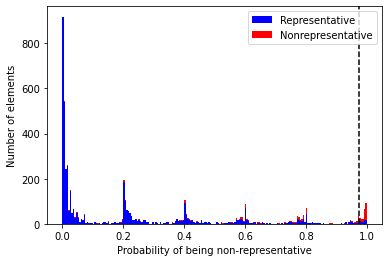

Divergence : 1.533015933887601
Temperature: 0.17983561347111443
Divergence : 1.5638362393788796
Temperature: 0.16285112483140882
Divergence : 1.5822904322971632
Temperature: 0.15345919228985042
Divergence : 1.6001105159990112
Temperature: 0.14490437567760087
Divergence : 1.541808163915067
Temperature: 0.1748174136074686
Divergence : 1.6291141742256792
Temperature: 0.13198850988675745
Divergence : 1.6372159201525194
Temperature: 0.1285909400091561
Divergence : 1.5041281373570519
Temperature: 0.19735998673476104
Divergence : 1.6625113065522787
Temperature: 0.11853563712780736


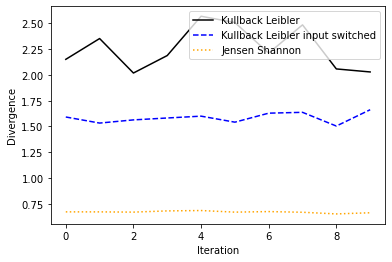

Divergence : 1.6497406401067676
Temperature: 0.12350984137103996


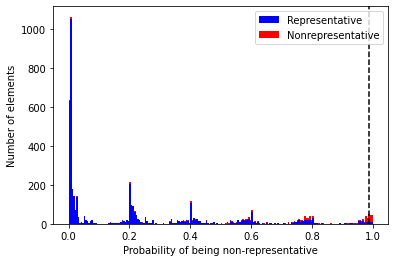

Divergence : 1.6293294917388021
Temperature: 0.13189706293945877
Divergence : 1.4685355427455762
Temperature: 0.22131732853255978
Divergence : 1.5321314511173716
Temperature: 0.1803483422266042
Divergence : 1.5501143378198885
Temperature: 0.17020533073404062
Divergence : 1.4034335242229932
Temperature: 0.27291294482866907
Divergence : 1.6379998477562383
Temperature: 0.12826686710228707
Divergence : 1.5244103260780024
Temperature: 0.1848867652697976
Divergence : 1.5348001204573163
Temperature: 0.1788057641339624
Divergence : 1.5009243357559925
Temperature: 0.19940581997298726


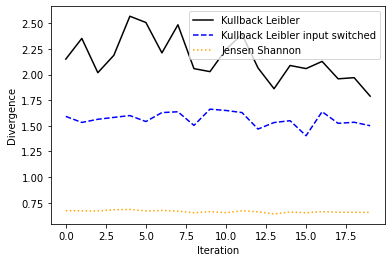

Divergence : 1.5682380263585716
Temperature: 0.16055998854848053


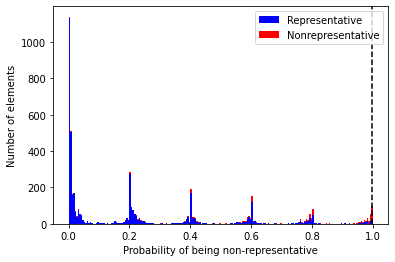

Divergence : 1.589573477121625
Temperature: 0.14990345694121762
Divergence : 1.45469476559755
Temperature: 0.23140034144171065
Divergence : 1.5294298435704232
Temperature: 0.1819235155556171
Divergence : 1.5597477682960665
Temperature: 0.1650084557554131
Divergence : 1.5634679095085429
Temperature: 0.1630443169490199
Divergence : 1.4794208792397538
Temperature: 0.21369697371638657
Divergence : 1.5725549972247097
Temperature: 0.15834431011538175
Divergence : 1.4158372378151531
Temperature: 0.2622312759719252
Divergence : 1.4113370885006973
Temperature: 0.2660574516043353


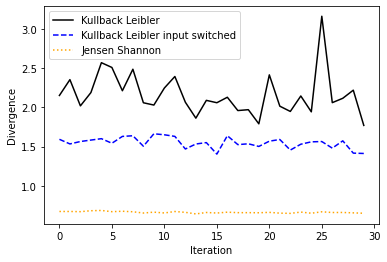

Divergence : 1.5757948576976082
Temperature: 0.15670156420192194


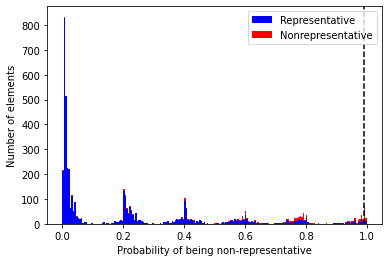

Divergence : 1.4174276959119831
Temperature: 0.26089221690501163
Divergence : 1.5427905261036639
Temperature: 0.1742654962011426
Divergence : 1.4993378287770196
Temperature: 0.20042674401787036
Divergence : 1.5332992228859985
Temperature: 0.17967170113599562
Divergence : 1.4201056461274613
Temperature: 0.2586529937157861
Divergence : 1.4732078809273976
Temperature: 0.21801369260424383
Divergence : 1.4381054124404336
Temperature: 0.2440927700444379
Divergence : 1.653172882082373
Temperature: 0.12215281946023322
Divergence : 1.4191661404465834
Temperature: 0.2594363836641296


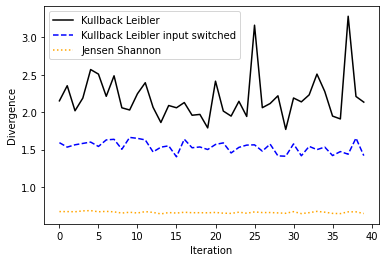

Divergence : 1.5288238149279334
Temperature: 0.18227874575392788


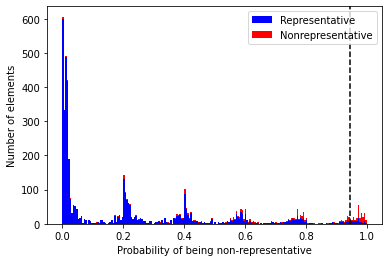

Divergence : 1.4552762732657016
Temperature: 0.2309676111757983
Divergence : 1.4690321064783813
Temperature: 0.22096386256721817
Divergence : 1.5113109538227718
Temperature: 0.19284925291548893
Divergence : 1.5397788431118329
Temperature: 0.17596308172595673
Divergence : 1.5164944258577697
Temperature: 0.1896582669809054
Divergence : 1.4225745903986264
Temperature: 0.2566055666286149
Divergence : 1.360547974385828
Temperature: 0.3133109414316831
Divergence : 1.3862576576970032
Temperature: 0.2884263716480604
Divergence : 1.3485956858880737
Temperature: 0.325599810792359


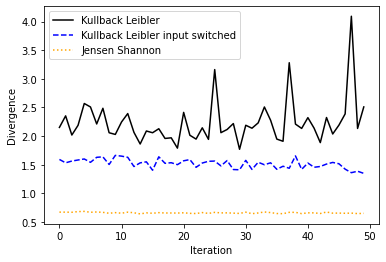

Divergence : 1.4367515558355106
Temperature: 0.24515882220812527


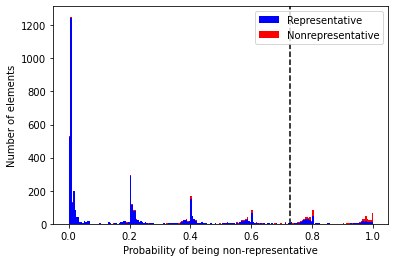

Divergence : 1.3752709542242756
Temperature: 0.29880903088711636
Divergence : 1.4504091409634707
Temperature: 0.23461460374518436
Divergence : 1.4505781988146786
Temperature: 0.23448696678620431
Divergence : 1.4977134940630927
Temperature: 0.2014774259793499
Divergence : 1.4111505801109139
Temperature: 0.26621722644496
Divergence : 1.3797695713318854
Temperature: 0.29451330690314087
Divergence : 1.423356905487632
Temperature: 0.25596020178505186
Divergence : 1.4546031494216478
Temperature: 0.2314685917185485
Divergence : 1.4681099919312697
Temperature: 0.2216206956811526


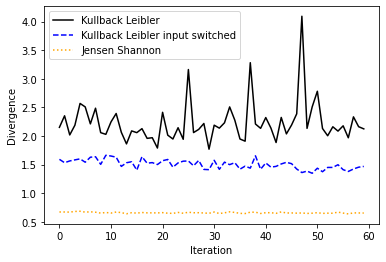

Divergence : 1.3134846752772948
Temperature: 0.36455850140984897


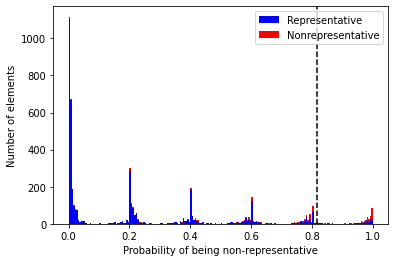

Divergence : 1.3845101453164275
Temperature: 0.29005334890602014
Divergence : 1.5001861285512208
Temperature: 0.19988021094910396
Divergence : 1.3115465204110865
Temperature: 0.3668399744746646
Divergence : 1.3080760203385497
Temperature: 0.37096095886219727
Divergence : 1.3847003792689372
Temperature: 0.2898757921598965
Divergence : 1.3807576189093054
Temperature: 0.2935781239744565
Divergence : 1.3750431754999561
Temperature: 0.29902819544247855
Divergence : 1.4258710514762682
Temperature: 0.25389714571371663
Divergence : 1.481146112020817
Temperature: 0.21251353719213406


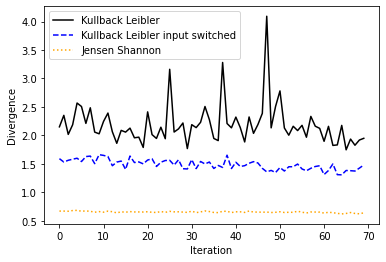

Divergence : 1.3473973446858658
Temperature: 0.326858176088532


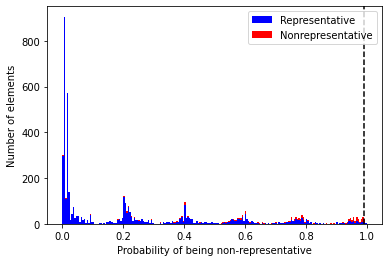

Divergence : 1.3208271947570758
Temperature: 0.3560433089541414
Divergence : 1.3793930493337834
Temperature: 0.2948704668125889
Divergence : 1.399396076174571
Temperature: 0.27648288072120225
Divergence : 1.5426443215985421
Temperature: 0.174347527309979
Divergence : 1.291189257295454
Temperature: 0.3916831484651874
Divergence : 1.4246648521562018
Temperature: 0.2548848444338635
Divergence : 1.3370349170440532
Temperature: 0.3379445174228907
Divergence : 1.3579283782615676
Temperature: 0.3159639975087043
Divergence : 1.2893155283196431
Temperature: 0.3940526457848688


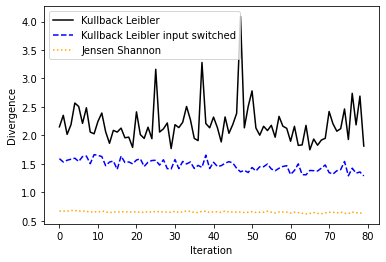

Divergence : 1.6383342246180312
Temperature: 0.12812888548547746


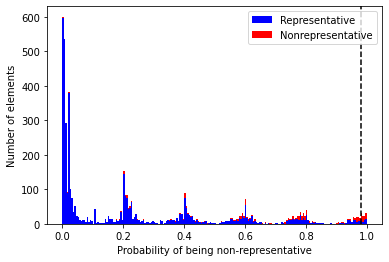

Divergence : 1.3712839504711425
Temperature: 0.30266856037191553
Divergence : 1.4965589421406047
Temperature: 0.20222758153985668
Divergence : 1.3858148726757034
Temperature: 0.2888377501960865
Divergence : 1.339729276046899
Temperature: 0.3350262628484649
Divergence : 1.4523348420403335
Temperature: 0.23316482133596084
Divergence : 1.437575992295089
Temperature: 0.2445090923724241
Divergence : 1.3211995320732077
Temperature: 0.35561684395937426
Divergence : 1.4065141353237613
Temperature: 0.2702200849273135
Divergence : 1.414333733131406
Temperature: 0.26350344502063583


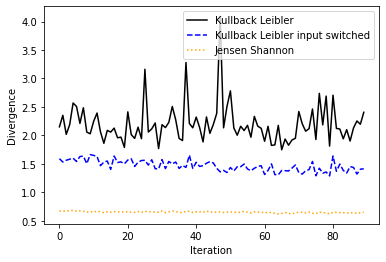

Divergence : 1.364035755899745
Temperature: 0.30981315344111443


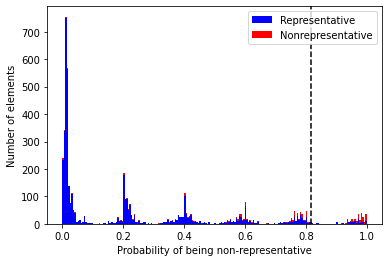

Divergence : 1.301742065555723
Temperature: 0.378601817300945
Divergence : 1.5953781479636446
Temperature: 0.14712858787323813
Divergence : 1.3014177247158645
Temperature: 0.37899728888058554
Divergence : 1.2811922149314352
Temperature: 0.40449220119369067
Divergence : 1.4702620384375307
Temperature: 0.22009079639617013
Divergence : 1.3036744177010564
Temperature: 0.37625422198144787
Divergence : 1.2965577502212429
Temperature: 0.3849728091147409
Divergence : 1.4514617624726593
Temperature: 0.23382101415619286
Divergence : 1.3583342013979374
Temperature: 0.3155515250090655


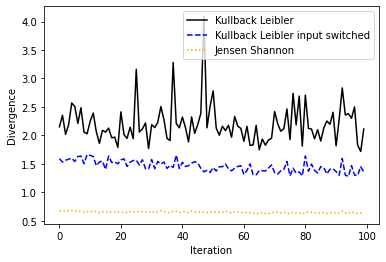

Divergence : 1.4257320476512618
Temperature: 0.2540107738689486


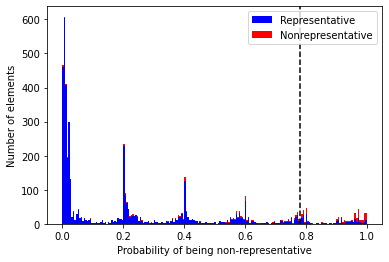

Divergence : 1.3549482899127736
Temperature: 0.3190094765840416
Divergence : 1.396604861964584
Temperature: 0.27897815374856816
Divergence : 1.4030373641069904
Temperature: 0.2732611827344711
Divergence : 1.2424655450907707
Temperature: 0.4581922232695056
Divergence : 1.3119657925630772
Temperature: 0.3663452266770791
Divergence : 1.3673510429192697
Temperature: 0.30652456153798113
Divergence : 1.5121215689611325
Temperature: 0.1923467131630681
Divergence : 1.1694158824718548
Temperature: 0.5796512273686488
Divergence : 1.2717936877322364
Temperature: 0.41691616073395404


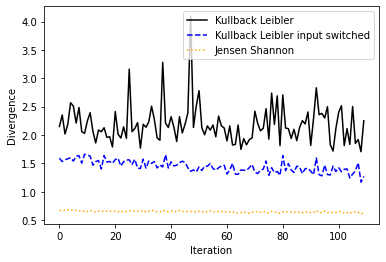

Divergence : 1.28284948633438
Temperature: 0.4023401621605895


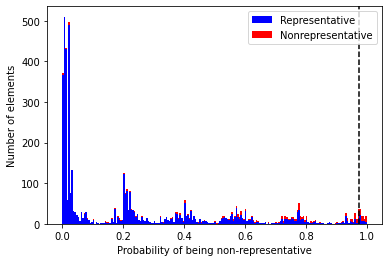

Divergence : 1.3000918736913107
Temperature: 0.3806182108728306
Divergence : 1.299794689177277
Temperature: 0.38098248447582017
Divergence : 1.3059964412090568
Temperature: 0.37345246667360105
Divergence : 1.6617420162962504
Temperature: 0.11882952469576426
Divergence : 1.3192084785017129
Temperature: 0.35790329508165725
Divergence : 1.439453603029042
Temperature: 0.24303578601294382
Divergence : 1.2464870767153227
Temperature: 0.45229923566654406
Divergence : 1.3774642985500474
Temperature: 0.2967068379254335
Divergence : 1.3509151173148852
Temperature: 0.32317794708066533


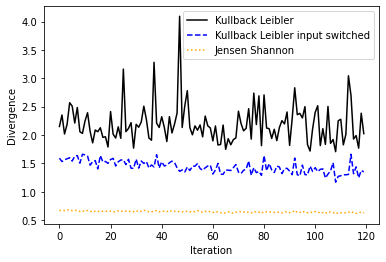

Divergence : 1.2896724917981441
Temperature: 0.39360013100020175


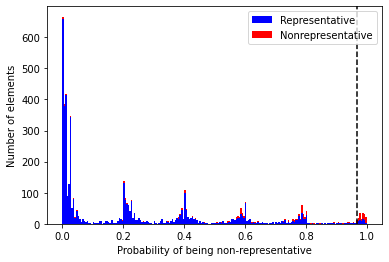

Divergence : 1.2866044659122564
Temperature: 0.3975064229616434
Divergence : 1.2297190422797433
Temperature: 0.47738257205356194
Divergence : 1.350993094129404
Temperature: 0.32309684034392877
Divergence : 1.3149636708795853
Temperature: 0.362827071272126
Divergence : 1.2965922147616578
Temperature: 0.3849301037258242
Divergence : 1.2124705012966968
Temperature: 0.5046368788545998
Divergence : 1.270887515568854
Temperature: 0.41813402029807595
Divergence : 1.2611826413776654
Temperature: 0.4314021806554171
Divergence : 1.195955835973657
Temperature: 0.5321885138009562


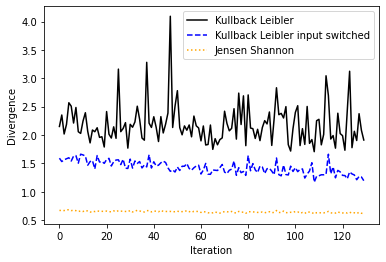

Divergence : 1.2352589188687118
Temperature: 0.4689452540136951


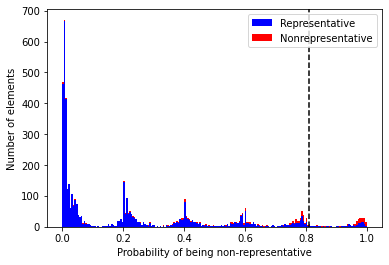

Divergence : 1.2100674936196012
Temperature: 0.5085553718968144
Divergence : 1.3295321553992916
Temperature: 0.3462053826585395
Divergence : 1.4112311936353081
Temperature: 0.26614815604971814
Divergence : 1.1787736570472
Temperature: 0.5624515945203328
Divergence : 1.3374080653788931
Temperature: 0.3375388498040751
Divergence : 1.2380953527774423
Temperature: 0.46468320968042026
Divergence : 1.2085621482424067
Temperature: 0.5110255668987619
Divergence : 1.1874215249398499
Temperature: 0.5470108640045073
Divergence : 1.1419246832316319
Temperature: 0.6332829667727494


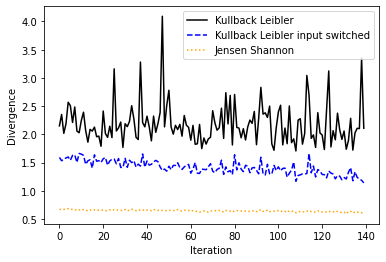

Divergence : 1.2671746190772355
Temperature: 0.42316126884609573


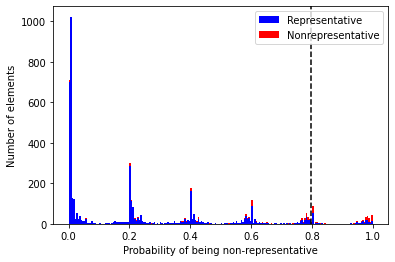

Divergence : 1.1683562763309832
Temperature: 0.5816316427600122
Divergence : 1.1946327508248202
Temperature: 0.5344598563667834
Divergence : 1.215782067444027
Temperature: 0.49928626002221493
Divergence : 1.2742324414366717
Temperature: 0.41365616227717167
Divergence : 1.250393319455043
Temperature: 0.4466477605614499
Divergence : 1.3427314486426472
Temperature: 0.33180428912931764
Divergence : 1.1285703924533075
Temperature: 0.6610987019848651
Divergence : 1.1255856356413374
Temperature: 0.667480857837055
Divergence : 1.1664274589172943
Temperature: 0.5852540081030275


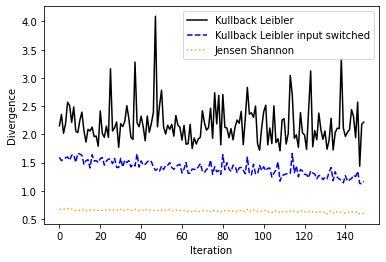

Divergence : 1.1993560467464515
Temperature: 0.5263955464419507


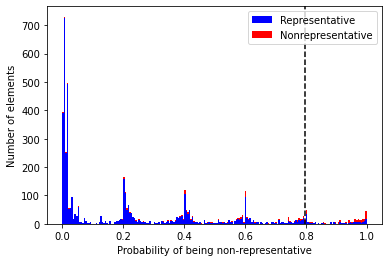

Divergence : 1.2037248684009245
Temperature: 0.5190448134305662
Divergence : 1.2207065204475396
Temperature: 0.4914343676714119
Divergence : 1.2485434616088602
Temperature: 0.4493152418193812
Divergence : 1.1250747368484046
Temperature: 0.6685794463839226
Divergence : 1.2062017980590318
Temperature: 0.5149229594463921
Divergence : 1.1741056065188893
Temperature: 0.5709667353817323
Divergence : 1.155910562109833
Temperature: 0.6054055353050033
Divergence : 1.2468713850154234
Temperature: 0.4517400690322807
Divergence : 1.1893230807500217
Temperature: 0.5436729065352033


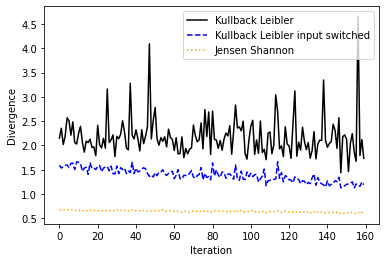

Divergence : 1.2182257573211612
Temperature: 0.49537431284941585


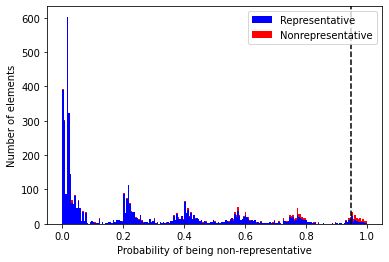

Divergence : 1.1940280578096831
Temperature: 0.5355011590720556
Divergence : 1.3716690407971908
Temperature: 0.30229361758410694
Divergence : 1.153472870001724
Temperature: 0.6101746135707375
Divergence : 1.201727322101884
Temperature: 0.5223929480084519
Divergence : 1.143112595447714
Temperature: 0.630866079869669
Divergence : 1.0914726802680557
Temperature: 0.7449492385110436
Divergence : 1.1480252663578427
Temperature: 0.6209684823793616
Divergence : 1.1398191859194593
Temperature: 0.6375895141786198
Divergence : 1.1601840495779268
Temperature: 0.5971346989150985


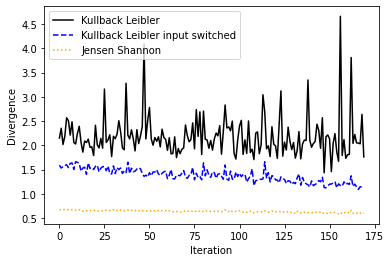

Divergence : 1.1109143673760715
Temperature: 0.6997587992780533


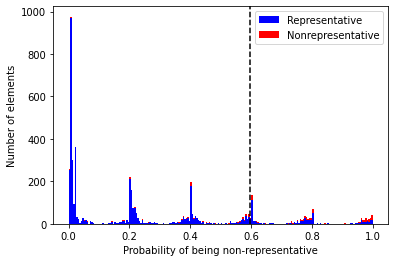

Divergence : 1.3178628731432884
Temperature: 0.35945685677837974
Divergence : 1.0671761579878656
Temperature: 0.8055486258057535
Divergence : 1.389221253596492
Temperature: 0.2856880254265143
Divergence : 1.1202448783361862
Temperature: 0.6790548786464728
Divergence : 1.2179505660405971
Temperature: 0.4958133130714365
Divergence : 1.0860669723326786
Temperature: 0.7580250119707626
Divergence : 1.2236238522567013
Temperature: 0.4868411392472369
Divergence : 1.2429637531282896
Temperature: 0.4574580230995855
Divergence : 1.1391235460494344
Temperature: 0.6390187904266434


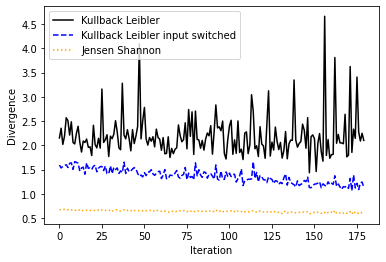

Divergence : 1.2242842679094528
Temperature: 0.48580731355158596


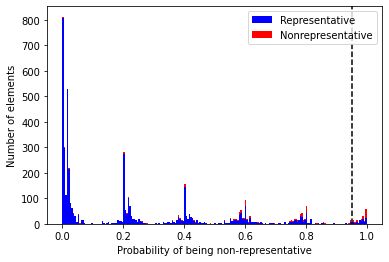

Divergence : 1.06325924431954
Temperature: 0.8157693263817075
Divergence : 1.1429810274636591
Temperature: 0.6311333088692598
Divergence : 1.180134925875309
Temperature: 0.5599924608483007
Divergence : 1.129050721947073
Temperature: 0.6600773531695436
Divergence : 1.1746701071765795
Temperature: 0.5699301979906701
Divergence : 1.284980796036054
Temperature: 0.3995893856842904
Divergence : 1.1221161728227333
Temperature: 0.6749769097148748
Divergence : 1.1432009139558714
Temperature: 0.6306867587696908
Divergence : 1.1650149238295546
Temperature: 0.5879210851273561


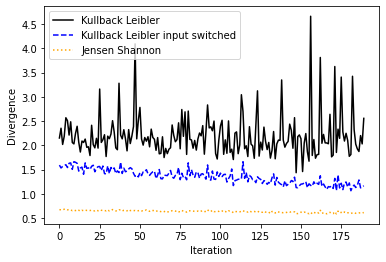

Divergence : 1.2201746005436653
Temperature: 0.49227651454095367


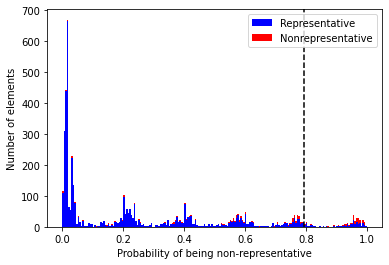

Divergence : 1.2428072238475356
Temperature: 0.4576885706305594
Divergence : 1.1783813231219418
Temperature: 0.5631623488228211
Divergence : 1.0451290402422586
Temperature: 0.8647932857377417
Divergence : 1.0139709416889089
Temperature: 0.9560254676798677
Divergence : 1.2126382568408605
Temperature: 0.5043644564387074
Divergence : 1.2029091864423296
Temperature: 0.5204093971874956
Divergence : 1.230912426002609
Temperature: 0.4755522942167485
Divergence : 1.1268119749551821
Temperature: 0.6648512148099734
Divergence : 1.0964782456636972
Temperature: 0.733042577177162


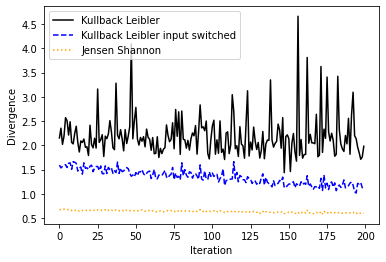

Divergence : 1.1075903104618972
Temperature: 0.7072862258940626


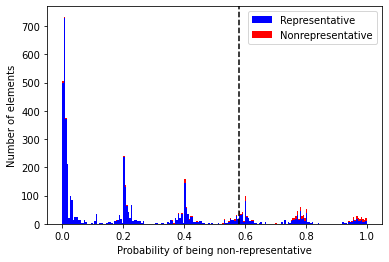

Divergence : 1.149969137904318
Temperature: 0.617095162682262
Divergence : 0.9756634024992934
Temperature: 1.081486501821735
Divergence : 1.2892176319407858
Temperature: 0.39417683775801715
Divergence : 1.1740258292946726
Temperature: 0.5711133744574185
Divergence : 1.1825278940794592
Temperature: 0.5556955950278963
Divergence : 1.2593887341680825
Temperature: 0.43390046016031764
Divergence : 1.0968908876881887
Temperature: 0.7320695645268991
Divergence : 1.1183746895563214
Temperature: 0.6831550537632679
Divergence : 1.0126429981436968
Temperature: 0.9601207308949933


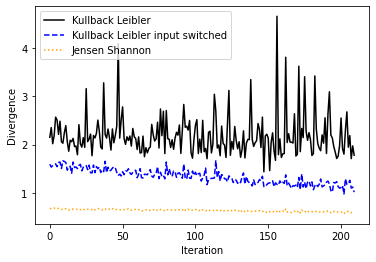

Divergence : 1.0720672348995597
Temperature: 0.7929655664386577


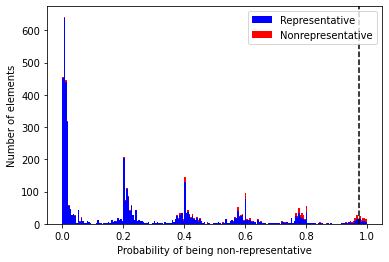

Divergence : 1.0460768671110117
Temperature: 0.8621588766616548
Divergence : 1.2066430958838417
Temperature: 0.5141920394403471
Divergence : 1.0754227266754823
Temperature: 0.7844469031244531
Divergence : 1.0436069420922403
Temperature: 0.8690406892876069
Divergence : 1.158956801079727
Temperature: 0.5994982616447506
Divergence : 1.1183326868542225
Temperature: 0.6832474235833496
Divergence : 1.152514362245296
Temperature: 0.6120601031217625
Divergence : 1.109134258403989
Temperature: 0.703779891351068
Divergence : 1.2185370412641725
Temperature: 0.4948782041242733


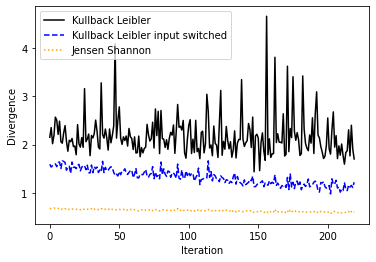

Divergence : 1.137485641393328
Temperature: 0.6423967295512756


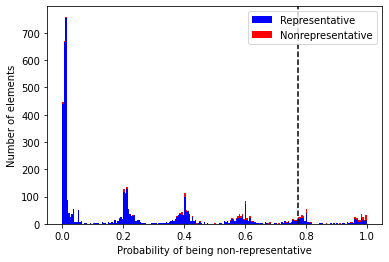

Divergence : 1.0241213626908159
Temperature: 0.9252940767099055
Divergence : 0.9784336049053218
Temperature: 1.0718858221630176
Divergence : 1.337815471688747
Temperature: 0.3370964947367205
Divergence : 1.0213354677863475
Temperature: 0.9336289201457231
Divergence : 1.1562413108372926
Temperature: 0.6047613398897531
Divergence : 1.0663428686734338
Temperature: 0.807712212846329
Divergence : 0.961076376583358
Temperature: 1.133477465639453
Divergence : 1.0187975499944026
Temperature: 0.9412871995226915
Divergence : 1.0929386471682623
Temperature: 0.7414422785763348


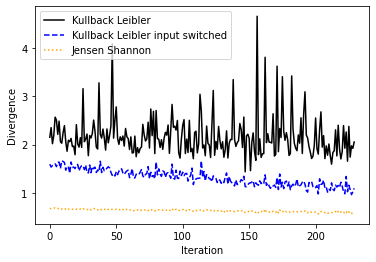

Divergence : 1.0807291128451892
Temperature: 0.7711618620069594


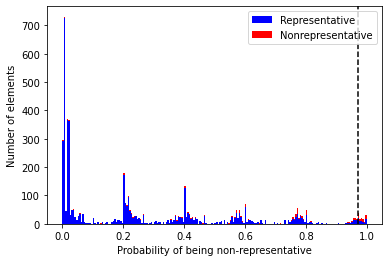

Divergence : 1.0537881979226968
Temperature: 0.8410219411794427
Divergence : 1.0533839419120192
Temperature: 0.8421170332358476
Divergence : 1.0549481339573576
Temperature: 0.8378876807367248
Divergence : 1.0731405067777466
Temperature: 0.7902308120153757
Divergence : 1.0250875981895877
Temperature: 0.9224207050784369
Divergence : 1.1101085501745056
Temperature: 0.7015762075029941
Divergence : 1.0563159463853198
Temperature: 0.8342067227155981
Divergence : 1.0836575542307147
Temperature: 0.7639268206591093
Divergence : 1.1199072010519393
Temperature: 0.6797933726800672


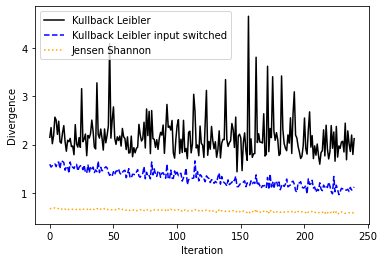

Divergence : 1.0653273243973878
Temperature: 0.8103568723416431


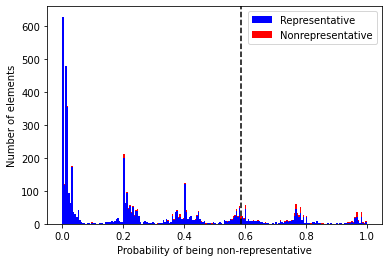

Divergence : 1.0775083326264823
Temperature: 0.7791983079975439
Divergence : 1.0532796491962126
Temperature: 0.8423997838462732
Divergence : 1.0515505858619705
Temperature: 0.8471013493938843
Divergence : 1.066088273627077
Temperature: 0.8083744122549278
Divergence : 0.9650997178684741
Temperature: 1.1188928554017825
Divergence : 1.0963028901930159
Temperature: 0.7334564580125027
Divergence : 1.0239186875412094
Temperature: 0.925897922689349
Divergence : 1.0039301545550434
Temperature: 0.9874290039898553
Divergence : 1.032923592856992
Temperature: 0.8994453736532863


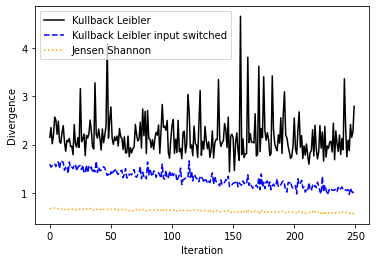

Divergence : 1.0398230400157344
Temperature: 0.8796902511694449


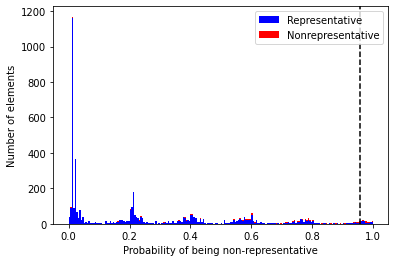

Divergence : 1.0979419339958987
Temperature: 0.7295970207879254
Divergence : 0.9353217229937099
Temperature: 1.2314487751864978
Divergence : 1.0197485361377234
Temperature: 0.938410224949018
Divergence : 1.1909756494662511
Temperature: 0.5407885638492589
Divergence : 1.0046527287639333
Temperature: 0.9851350347022519
Divergence : 0.8851389852203434
Temperature: 1.4473341451516206
Divergence : 0.8918516956197003
Temperature: 1.416396489052743
Divergence : 1.0106404768304285
Temperature: 0.9663295309100361
Divergence : 1.0239632715802958
Temperature: 0.9257650561629549


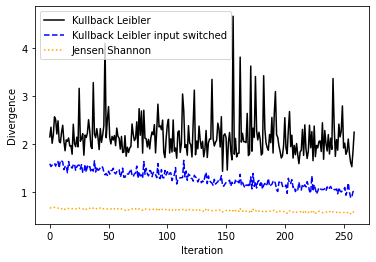

Divergence : 0.9762693287489872
Temperature: 1.0793792247672604


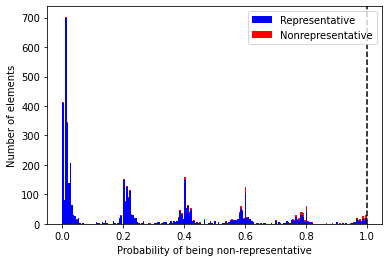

Divergence : 0.9347481213595252
Temperature: 1.2337245639366798
Divergence : 1.0008477358303849
Temperature: 0.9972749633012354
Divergence : 0.9414593843979662
Temperature: 1.2073585687244426
Divergence : 1.0197276911222508
Temperature: 0.9384731920568966
Divergence : 0.9384809478929863
Temperature: 1.218989442404888
Divergence : 0.977360342693349
Temperature: 1.075595267558756
Divergence : 0.9860036607994824
Temperature: 1.046082754683219
Divergence : 1.058911490780261
Temperature: 0.8272661800935394
Divergence : 0.9775688409623405
Temperature: 1.0748736454446386


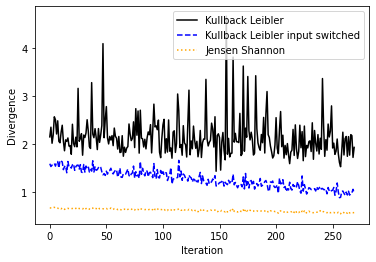

Divergence : 0.9600451767528825
Temperature: 1.1372460732747838


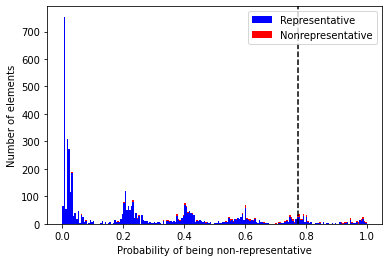

Divergence : 0.9427144279446333
Temperature: 1.2024908850905411
Divergence : 1.0023985866747567
Temperature: 0.9923089757917252
Divergence : 1.1731415704088846
Temperature: 0.5727412612646156
Divergence : 0.975275328820663
Temperature: 1.08283829669174
Divergence : 0.9455248680805239
Temperature: 1.191661658953332
Divergence : 1.023801453481022
Temperature: 0.926247387205316
Divergence : 0.9601826802845049
Temperature: 1.1367428318138202
Divergence : 0.9313250344817195
Temperature: 1.2473935149970201
Divergence : 0.9438063909090483
Temperature: 1.1982716774460807


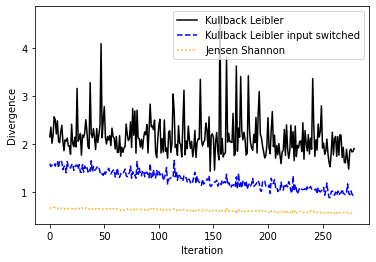

Divergence : 1.0493570455024936
Temperature: 0.8531036721875952


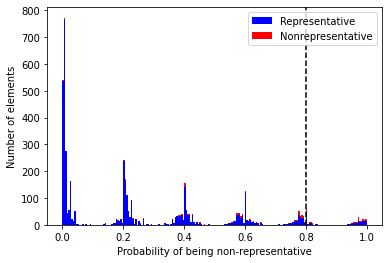

Divergence : 0.9799504165375593
Temperature: 1.0666651715939612
Divergence : 0.9187175003593532
Temperature: 1.299056553702221
Divergence : 0.9411165351475385
Temperature: 1.2086917320546755
Divergence : 1.0003663017380235
Temperature: 0.9988216150323489
Divergence : 0.9704170493632113
Temperature: 1.0999050354110251
Divergence : 1.0677809669769822
Temperature: 0.8039819052307002
Divergence : 0.8721109472816332
Temperature: 1.5093196404633475
Divergence : 0.8219703183499201
Temperature: 1.7736781448569239
Divergence : 1.0409319777650414
Temperature: 0.8765557655181008


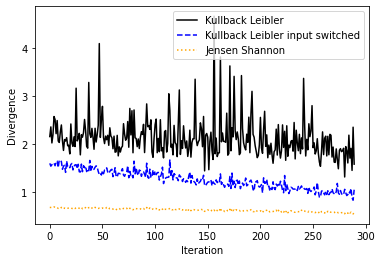

Divergence : 0.9364412595820589
Temperature: 1.227019052097908


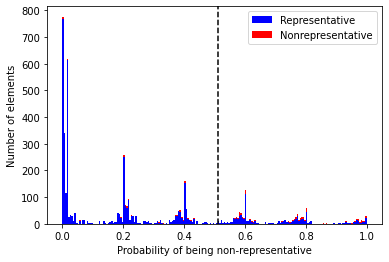

Divergence : 0.8698917203356795
Temperature: 1.5201399394174948
Divergence : 1.01324281902536
Temperature: 0.9582687672298676
Divergence : 0.977416045253552
Temperature: 1.0754024310195305
Divergence : 0.9722068076134077
Temperature: 1.093586689483359
Divergence : 1.497481768014214
Temperature: 0.20162776352407769
Divergence : 0.9478090605225352
Temperature: 1.1829320603266635
Divergence : 1.123874412306069
Temperature: 0.6711676306418777
Divergence : 0.89950820529397
Temperature: 1.3819155392067788
Divergence : 1.068840789314555
Temperature: 0.8012438450276954


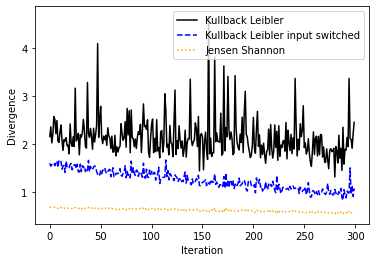

Divergence : 1.0632687213418721
Temperature: 0.8157444414258628


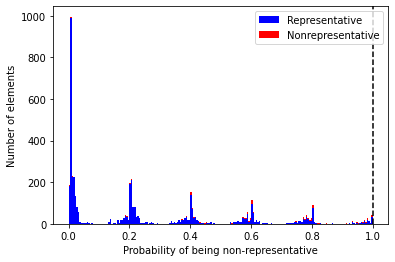

Divergence : 0.8648088273245192
Temperature: 1.5452158316605618
Divergence : 0.9514831820239965
Temperature: 1.16902446741735
Divergence : 0.9932151246647294
Temperature: 1.0220799024802767
Divergence : 1.0966848662123998
Temperature: 0.7325552029937543
Divergence : 0.8297079828714674
Temperature: 1.7300474867182791
Divergence : 0.8160475894378265
Temperature: 1.8078168684844853
Divergence : 0.9432652055542692
Temperature: 1.2003608960297951
Divergence : 0.930465331211402
Temperature: 1.2508501802911134
Divergence : 0.9766877839493563
Temperature: 1.0779263278825135


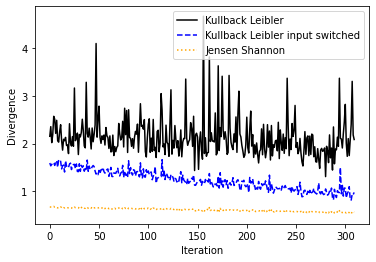

Divergence : 1.0598623184312228
Temperature: 0.8247381230707672


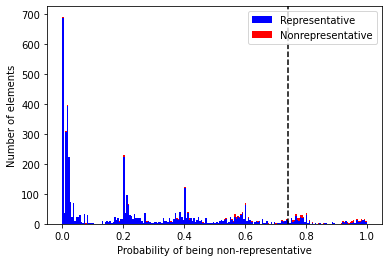

Divergence : 0.8681055759327178
Temperature: 1.5289049696679555
Divergence : 0.9138605670884234
Temperature: 1.3195254154056706
Divergence : 0.94116885022819
Temperature: 1.2084882106424404
Divergence : 1.079748214094386
Temperature: 0.7736005696933449
Divergence : 1.00377873274184
Temperature: 0.9879104021086561
Divergence : 0.9736003597458495
Temperature: 1.0886922048208374
Divergence : 0.9239296101630545
Temperature: 1.2774439135374425
Divergence : 0.7619685387694739
Temperature: 2.1515611955899305
Divergence : 0.9180092974628005
Temperature: 1.302021283283848


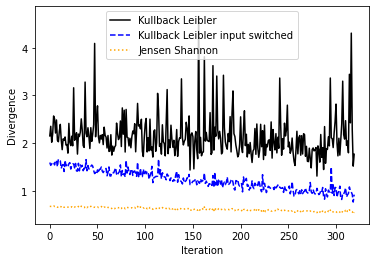

Divergence : 1.0298853384411024
Temperature: 0.9082848905986802


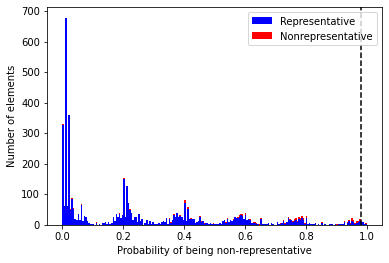

Divergence : 0.995589434865019
Temperature: 1.0142983183804244
Divergence : 0.9069231149116344
Temperature: 1.3493229326418126
Divergence : 0.9195316977606495
Temperature: 1.2956564433067679
Divergence : 0.9799730509548981
Temperature: 1.0665874599964873
Divergence : 0.9139934222027758
Temperature: 1.318961248765995
Divergence : 1.014747222050185
Temperature: 0.9536395810667505
Divergence : 0.912905157535883
Temperature: 1.3235896571826702
Divergence : 0.8690255039008369
Temperature: 1.5243843736848433
Divergence : 0.8138062826651248
Temperature: 1.8209065026565758


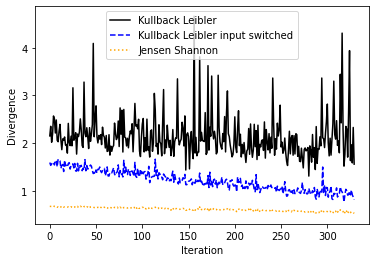

Divergence : 0.9993443453702736
Temperature: 1.0021126994481968


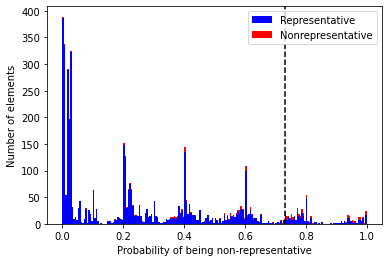

Divergence : 0.8618231963093237
Temperature: 1.56013752270715
Divergence : 1.03173777479719
Temperature: 0.9028851181988222
Divergence : 0.9045648481395849
Temperature: 1.3596045741457206
Divergence : 0.8040422277277531
Temperature: 1.879045125536392
Divergence : 0.8060872379947441
Temperature: 1.8667166803377349
Divergence : 0.9902002263772086
Temperature: 1.0320470472115986
Divergence : 0.8721417433011344
Temperature: 1.5091700311921705
Divergence : 0.9153387205699103
Temperature: 1.31326203573925
Divergence : 0.8858679616446328
Temperature: 1.4439419792737391


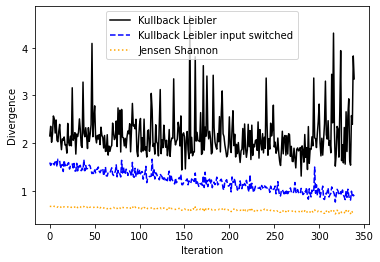

Divergence : 1.05515845295943
Temperature: 0.8373206304917967


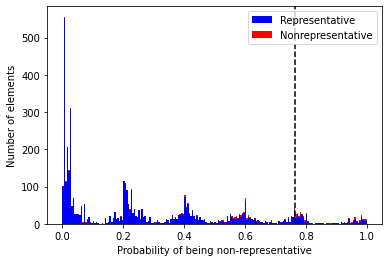

Divergence : 0.9241544554919511
Temperature: 1.27651969902535
Divergence : 1.280306850853004
Temperature: 0.40564659838969663
Divergence : 0.9565614864703478
Temperature: 1.1500704266540926
Divergence : 0.8435755835323114
Temperature: 1.6545197287188143
Divergence : 0.9748097613646989
Temperature: 1.0844622588432087
Divergence : 0.882755169647798
Temperature: 1.458482555986112
Divergence : 0.871275222571349
Temperature: 1.5133853183482926
Divergence : 1.0698338610721818
Temperature: 0.7986866984781721
Divergence : 0.9840377912147832
Temperature: 1.0527232393407338


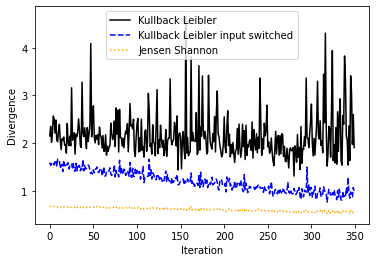

Divergence : 0.931555778200531
Temperature: 1.2464673756836588


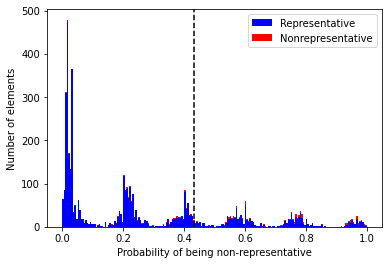

Divergence : 0.869077586606185
Temperature: 1.524128835478283
Divergence : 0.9688144386242463
Temperature: 1.1055936710839824
Divergence : 0.7674631770139905
Temperature: 2.113842027640901
Divergence : 0.8015628428830873
Temperature: 1.8941014700468943
Divergence : 0.9522802322623158
Temperature: 1.1660290556954738
Divergence : 1.1537053497227636
Temperature: 0.6097181764600652
Divergence : 0.8508665047404824
Temperature: 1.616142606123473
Divergence : 0.8437502730715507
Temperature: 1.6535896472840246
Divergence : 0.9980634286791369
Temperature: 1.0062530518172088


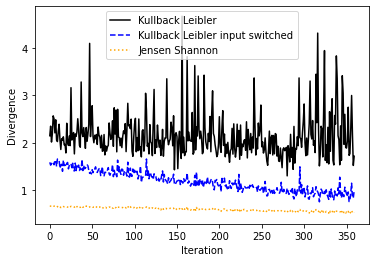

Divergence : 1.0637275449941088
Temperature: 0.8145405606503447


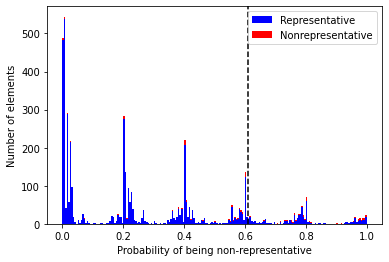

Divergence : 0.7891298154440614
Temperature: 1.9714413781555546
Divergence : 0.8966529337396444
Temperature: 1.3946749441243644
Divergence : 0.9192295218667047
Temperature: 1.296917298254132
Divergence : 0.9274481023247766
Temperature: 1.263057728132059
Divergence : 1.0361504892926265
Temperature: 0.8901512062342458
Divergence : 0.8558584621058669
Temperature: 1.5903811614523364
Divergence : 0.977641556513567
Temperature: 1.0746220874560732
Divergence : 0.8904218693847561
Temperature: 1.4229303835111478
Divergence : 0.9190372697795455
Temperature: 1.2977201252262223


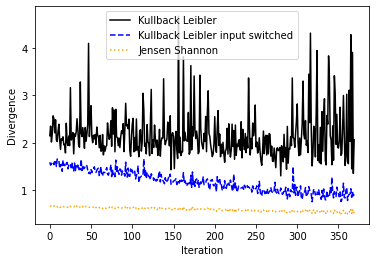

Divergence : 0.9088758668786082
Temperature: 1.340868139070005


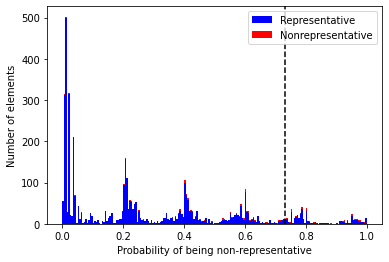

Divergence : 0.707492782029236
Temperature: 2.563938140315933
Divergence : 0.8716719658711478
Temperature: 1.5114538568355547
Divergence : 0.8131564820925786
Temperature: 1.8247191464315349
Divergence : 0.878367317297288
Temperature: 1.4792282541359896
Divergence : 0.9118871646706743
Temperature: 1.3279338997119365
Divergence : 0.9275010615781385
Temperature: 1.2628424339664053
Divergence : 0.8964557272505007
Temperature: 1.3955605414003287
Divergence : 1.0188526282494514
Temperature: 0.9411203334474584
Divergence : 0.8114796337672948
Temperature: 1.8345948177546085


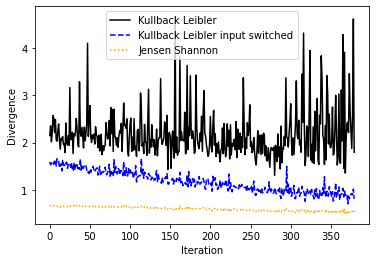

Divergence : 0.7957233165213672
Temperature: 1.9300410614122743


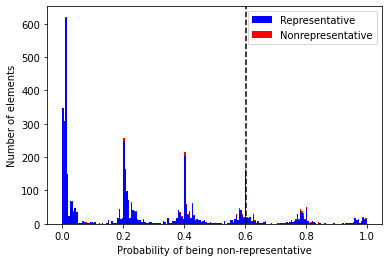

Divergence : 0.8781753503222949
Temperature: 1.4801425781452815
Divergence : 0.9855330651759188
Temperature: 1.0476685499726688
Divergence : 0.8443486306911157
Temperature: 1.6504078344692024
Divergence : 0.9841619130190489
Temperature: 1.0523027260187907
Divergence : 0.9758620950034018
Temperature: 1.0807950404284097
Divergence : 0.885069367715661
Temperature: 1.447658514751659
Divergence : 0.8918732023335257
Temperature: 1.4162984389419926
Divergence : 0.8381188273629032
Temperature: 1.683837463588474
Divergence : 0.9103585097263738
Temperature: 1.3344841676986707


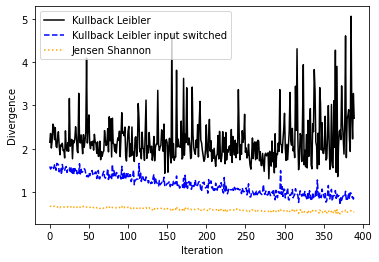

Divergence : 1.052287364274813
Temperature: 0.8450947457097027


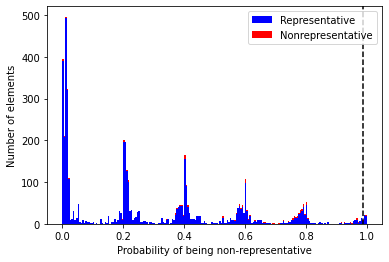

Divergence : 0.8731789372952641
Temperature: 1.5041399195623362
Divergence : 0.8404043216255395
Temperature: 1.6714953933439494
Divergence : 0.9078014148395744
Temperature: 1.3455135972545818
Divergence : 0.9388428653554723
Temperature: 1.2175701863334065
Divergence : 0.8910218834334941
Temperature: 1.420184829632071
Divergence : 0.8734595737463187
Temperature: 1.502781792514335
Divergence : 1.0256611515402827
Temperature: 0.9207193057687325
Divergence : 1.1444107718983976
Temperature: 0.6282353996673793
Divergence : 0.8639970255954174
Temperature: 1.549258898237433


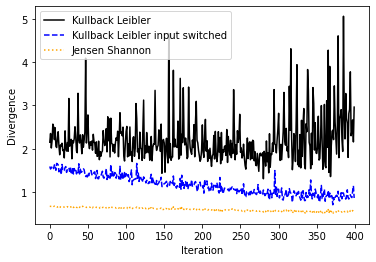

Divergence : 0.8233923244226745
Temperature: 1.7655781092410483


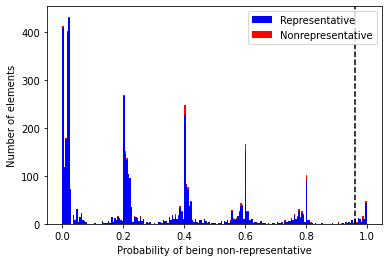

Divergence : 0.9623346439753941
Temperature: 1.1288959321937473
Divergence : 0.7896987035787497
Temperature: 1.9678346169354688
Divergence : 0.9959419591824741
Temperature: 1.013148014384641
Divergence : 0.9035164552901437
Temperature: 1.364200509290967
Divergence : 0.9866039853155539
Temperature: 1.0440632874827716
Divergence : 0.8074057889866947
Temperature: 1.8588106539501876
Divergence : 0.8895847676540418
Temperature: 1.426769677387923
Divergence : 0.8958070299848625
Temperature: 1.3984776222813653
Divergence : 0.9227731302644439
Temperature: 1.2822081438563444


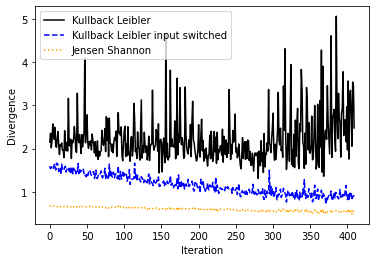

Divergence : 0.8573933875308128
Temperature: 1.5825428899823824


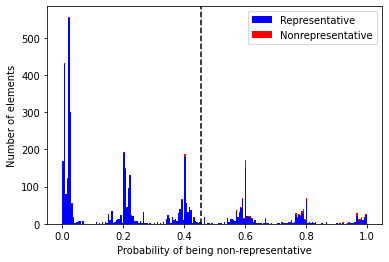

Divergence : 0.8223768598828683
Temperature: 1.771358615737954
Divergence : 0.9755834537485347
Temperature: 1.0817648528894312
Divergence : 0.7883026096554013
Temperature: 1.9766976761180648
Divergence : 1.017952877492065
Temperature: 0.9438499437667078
Divergence : 0.8633761350130044
Temperature: 1.5523582962564302
Divergence : 1.0536441950578141
Temperature: 0.8414118682070627
Divergence : 0.8525135973418497
Temperature: 1.607596836921806
Divergence : 0.7920851846415748
Temperature: 1.9527760445489604
Divergence : 0.9617528236754731
Temperature: 1.1310121177193753


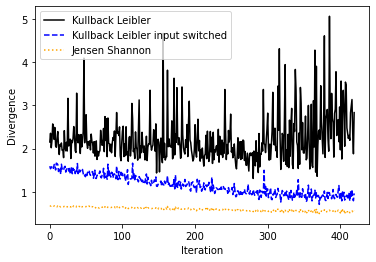

Divergence : 1.0399192705670923
Temperature: 0.8794178056212647


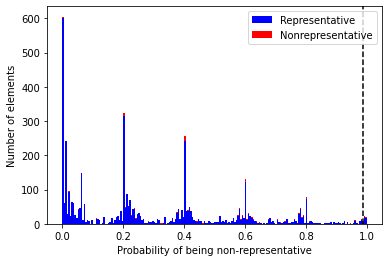

Divergence : 0.7061417596056322
Temperature: 2.575112405910545
Divergence : 0.7991776797114726
Temperature: 1.9086994843017204
Divergence : 0.8940045947672348
Temperature: 1.4066149136386568
Divergence : 0.8486100087092915
Temperature: 1.6279239994280954
Divergence : 0.8544694051217036
Temperature: 1.5975079976847262
Divergence : 0.7832948738823982
Temperature: 2.008818807927465
Divergence : 1.0530361103418049
Temperature: 0.8430604179146872
Divergence : 0.7546351913046236
Temperature: 2.2029532598033836
Divergence : 0.8671145895787521
Temperature: 1.5337897523084767


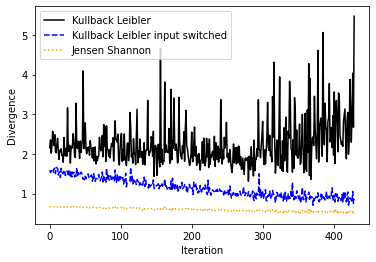

Divergence : 0.9268135479996902
Temperature: 1.2656402252298822


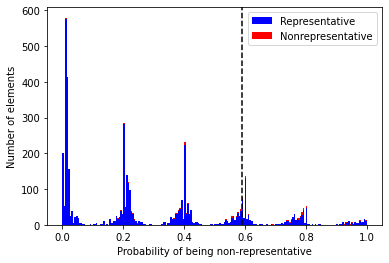

Divergence : 0.8189229549831777
Temperature: 1.7911619129385994
Divergence : 0.9608747521916493
Temperature: 1.1342133356781696
Divergence : 0.8277391046883652
Temperature: 1.7410466084173049
Divergence : 0.9719385517430527
Temperature: 1.0945313900800158
Divergence : 0.7528717090125747
Temperature: 2.2154937297960617
Divergence : 0.8547044291157495
Temperature: 1.5962999190539304
Divergence : 0.8830764415065255
Temperature: 1.4569750688731113
Divergence : 0.6031239185794511
Temperature: 3.587640786548815
Divergence : 0.9010025813032706
Temperature: 1.3752841960079007


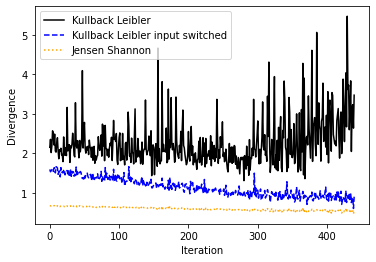

Divergence : 0.9576512765857179
Temperature: 1.1460431634356356


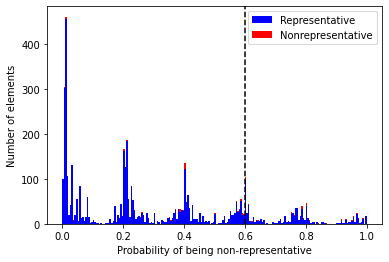

Divergence : 0.8740824757002801
Temperature: 1.4997716675615187
Divergence : 0.7271470902436139
Temperature: 2.406755644518494
Divergence : 0.8773141515862395
Temperature: 1.484251361568235
Divergence : 0.9398878447721668
Temperature: 1.2134815756410593
Divergence : 0.9741629533313867
Temperature: 1.0867224556062045
Divergence : 0.6638668482000618
Temperature: 2.9504888729492955
Divergence : 0.7288013158236574
Temperature: 2.3939743390801893
Divergence : 0.9129739748035084
Temperature: 1.3232964956978084
Divergence : 0.7761144950519359
Temperature: 2.055788842831677


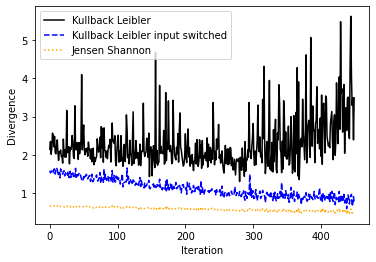

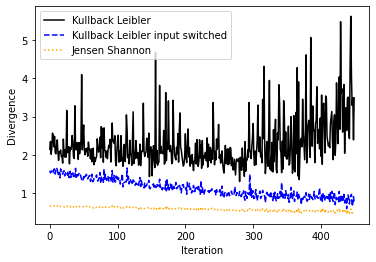

In [238]:
drop = 1
number_of_splits = 5
result_dir = os.path.join(os.getcwd(), 'results/gbs_mrs',  datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

test_size = 0.3
number_of_iterations = 450

for temp in tqdm(temperatures):
    gbs_mrs, _, _ = repeated_MRS(scaled_gesis_gbs, gesis_columns,
                    number_of_iterations=number_of_iterations, number_of_splits=number_of_splits,
                        n_drop=drop, test_size=test_size, cv=5, directory=result_dir,
                                 grid_search=grid_search_tree)

In [266]:
gbs_mrs.Wahlabsicht.value_counts()

1.0    124
0.5      3
0.0      2
Name: Wahlabsicht, dtype: int64

## Preprocessing GBS

**Run only if you want to recreate the data from the raw data - pocessed data is already saved**

## GBS Prediction: Participation in Elections (Wahlteilnahme)

In [37]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

gbs__ = pd.read_csv(os.path.join(path, 'data/GBS/gbs1_p.csv'), sep=" ")
gbs__.columns = ['col']

personen = []

for i in range(gbs__.shape[0]):
    person_data = str(gbs__.loc[i].values)
    if ('mehrere Personen' in person_data):
        personen.append(int (person_data.split("mehrere Personen, und zwar:\",",1)[1][0]))
    else:
        personen.append(1)
        
gbs1['am24'] = personen

df = pd.merge(gbs1, gbs2, how='inner', on=key)
df = pd.merge(df, mapping1, how='left', on=key)
df = pd.merge(df, mapping2, how='left', on=key)

attributes1 = ['am01','am02_01','am02_02', 'am11','am10','am23','am14','am15','am17','am22','am24','am29','am27']
attributes2 = ['gh03_08','gh08_03','gh04_01','gh05_01','pt04',
               'pt03_01','pt01_02','gh07_01','gh04_01','gh03_10','gh03_07','gh03_13','gh03_11']
attributes3 = ['v2673_1_bfi_bfi1','v2673_1_bfi_bfi2','v2673_1_bfi_bfi3','v2673_1_bfi_bfi4','v2673_1_bfi_bfi5',
               'v2673_1_bfi_bfi6','v2673_1_bfi_bfi7','v2673_1_bfi_bfi8','v2673_1_bfi_bfi9','v2673_1_bfi_bfi10']
attributes4 = ['gh03_09','lo01_04','pt06_01','br01_06']

attributes5 = ['br01_01', 'br01_02', 'br01_03', 'br01_04', 'br01_05', 'br01_06',
           'am20_01', 'so01_01', 'so02_01', 'am14']

attribute_name1 = ['Geschlecht','Geburtsjahr','Alter', 'Geburtsland','Nationalitaet','Familienstand','Hoechster Bildungsabschluss',
                    'Berufliche Ausbildung','Erwerbstaetigkeit','Berufsgruppe','Personen im Haushalt',
                    'Nettoeinkommen Selbst','Nettoeinkommen Haushalt']
attribute_name2 = ['Schlechter Schlaf','Leben genießen','Zu Nichts aufraffen','Alles anstrengend','Wahlteilnahme','Wahlabsicht',
                    'Desinteresse Politiker','Zufriedenheit Leben','Aktiv','Verärgert','Wach','Nervös','Ängstlich']
attribute_name3 = ['Zurueckhaltend','leicht Vertrauen','Faulheit','Entspannt','wenig kuenstlerisches Interesse','Gesellig',
                    'Andere kritisieren','Gruendlich','Nervoes','Phantasievoll']
attribute_name4 = ['Druck','Optimismus Zukunft','Zufriedenheit Wahlergebnis','Resilienz']
attribute_name5 = ['BRS1', 'BRS2', 'BRS3', 'BRS4', 'BRS5', 'BRS6',
         'woechentlicheArbeitszeit', 'Optimismus', 'Pessimismus', 'Schulabschluss']

df = df[[key] + ['Gruppe'] + attributes1 + attributes2 +  attributes3 + attributes4 + attributes5]
df.columns = [key] + ['Gruppe'] + attribute_name1 + attribute_name2 + attribute_name3 + attribute_name4 + attribute_name5

df = df.sort_values(by=['GBS-CODE'])

*Almost every survey participant is counted twice in the dataframe (due to previous joins). The next code snippet gets rid of duplicate entries by merging them and avering column values. They are almost (or near) identical, so this should be fine.*

In [341]:
def merge(arr1, arr2):
    result = []
    for i,j in zip(arr1, arr2):
        if(i != i):
            result.append(j)
        else:
            result.append(i)
    return result

tmp = pd.DataFrame(columns=df.columns)

j = 0
skip = False

for i in range(len(df.Gruppe)-1):
    if(not skip):
        if(df.iloc[i]["GBS-CODE"] == df.iloc[i+1]["GBS-CODE"]):
            tmp.loc[j] = merge(df.iloc[i].values, df.iloc[i+1].values)
            j = j+1
            skip = True
        else:
            tmp.loc[j] = df.iloc[i].values
            j = j+1
    else:
        skip = False
        
df = tmp.copy()
del tmp

In [ ]:
rep1 = {
    '5 Trifft voll und ganz zu':5,
    '4 Eher zutreffend':4,
    '3 Weder noch':3,
    '2 Trifft eher nicht zu':2,
    '1 Trifft überhaupt nicht zu':1,
    
    'trifft voll und ganz zu (5)':5,
    'eher zutreffend (4)':4,
    'weder noch (3)':3,     
    'trifft eher nicht zu (2)':2,
    'trifft ueberhaupt nicht zu (1)':1, 
    
    'Unit nonresponse':np.nan,
    'Not in panel':np.nan,
    'Item nonresponse':np.nan,
    'Not reached':np.nan,
    'Ambiguous answer':np.nan,
    'keine Angabe':np.nan,
     
    -1:np.nan,
    -9:np.nan
}
rep2 = {
     True:1,
     False:0,
    'Ja':1,
    'Nein':0,
    'True':1,
    'False':0,
    
    'Ja, ich würde wählen.':1,
    'Weiß ich nicht':0.5,
    'Ich war nicht wahlberechtigt.':0.5,
    'Ich bin nicht wahlberechtigt.':0.5,
    'Ich war nicht wahlberechtigt':0.5,
    'Ja, ich würde wählen.':1,
    'Nein, ich würde nicht wählen.':0,
    
    'Nie':1,
    'Fast nie':2,
    'Manchmal':3,
    'Meistens':4,
    'Fast Immer':4,
    'Fast immer':4,
    'Immer':4,
    
    'Gar nicht':1,
    'Ein bisschen':2,
    'Einigermaßen':3,
    'Äußerst':4,
    'Erheblich':4
}

df = df.replace(rep1)
df = df.replace(rep2)

di1 = {'männlich': 0, "Männlich": 0, 'weiblich': 1, "Weiblich": 1, '[NA] Keine Angabe':np.nan}
df = df.replace({"Geschlecht": di1})

df['Geburtsjahr'] = df['Geburtsjahr'].astype(str).str[0:4].astype(int)

di3 = {'Türkei':0, 'Österreich': 0, 
       'Item nonresponse': np.nan, 'sonstige, und zwar:': 0, 'Europa':0, 'Deutschland':1, 'Andere':0}
df = df.replace({'Geburtsland': di3})

di4 = {2.0: 0, 2:0}
df = df.replace({'Nationalitaet': di4})

di5 = {'Verheiratet/ Eing. LP zus. lebend':1,
       'Verheiratet und lebe mit meinem/r Ehepartner/-in zusammen': 1, 
       'Geschieden/ Eing. LP aufgehoben': 2,
       'Geschieden': 2,
       'Ledig': 2,
       'In eingetragener Lebenspartnerschaft zusammenlebend (gleichgeschlechtlich)':1,
       'Verheiratet und lebe von meinem/meiner Ehepartner/-in getrennt': 0,
       'Eingetragene Lebenspartnerschaft, getrennt lebend (gleichgeschlechtlich)': 0,
       'Eingetragene/r Lebenspartner/-in verstorben (gleichgeschlechtlich)': 0,
       'Verheiratet/ Eing. LP getrennt lebend': 0,
       'Geschieden/ Eing. LP aufgehoben': 1,
       '[NA] Keine Angabe':np.nan,
       'Verwitwet': 1,
       'Verwitwet/ Eing. LP verstorben': 1,
       'Item nonresponse':np.nan}
df = df.replace({'Familienstand': di5})

di6 = {'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 3,
       'Abitur, allgemeine oder fachgebundene Hochschulreife': 3,
       'Item nonresponse':np.nan, 
       'Anderer Schulabschluss:':np.nan, 
       'Anderer Schulabschluss':np.nan,
       'Fachhochschulreife, Fachoberschule': 3,
       'Realschulabschluss':2,
       'Polytechnische Oberschule DDR, Abschluss 10. Klasse': 2,
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 2,
       'Schüler/-in': np.nan,
       'Hauptschulabschluss':1,
       'Hochschulabschluss':3,
       'Hauptschulabschluss/Volksschulabschluss': 1,
       'Von der Schule abgegangen ohne Hauptschulabschluss':np.nan,
       'Realschulabschluss (Mittlere Reife)': 2,
       'Polytechnische Oberschule DDR, Abschluss 8.oder 9. Klasse': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 2}
df = df.replace({'Hoechster Bildungsabschluss': di6})

di7 = {1.0: 51,
       2.0: 52,
       3.0:np.nan,
       4.0:np.nan,
      -1.0:np.nan,
      'Geringfügig erwerbstätig, 400-Euro-Job, Minijob':53,
      'Item nonresponse':np.nan,
      'In einer beruflichen Ausbildung/Lehre':50,
      'In Umschulung':54,
      'Altersteilzeit (nicht mehr am Arbeitsplatz)':54,
      '\'Ein-Euro-Job\' (bei Bezug von Arbeitslosengeld II)':52,
      'Gelegentlich oder unregelmäßig beschäftigt':52,
      'Freiwilliger (Wehr-)Dienst':51,
      'Mutterschafts-, Erziehungsurlaub, Elternzeit oder sonstige Beurlaubung':52,
      'Vollzeiterwerbstätig':51,
      'Nicht erwerbstätig':52,
      'Teilzeiterwerbstätig':53}
#df = df.replace({'Erwerbstaetigkeit': di7})

di9 = {'Item nonresponse':np.nan,
        'Missing by filter': np.nan,
       'Angabe verweigert':np.nan,
       'Weiß nicht':np.nan,     
'6000 € und mehr'                     :4,
'5000 bis unter 6000 €'               :4,
'4000 bis unter 5000 €'               :4,
'3200 bis unter 4000 €'               :3,
'2600 bis unter 3200 €'               :2,
'2300 bis unter 2600 €'               :2,
'2000 bis unter 2300 €'               :2,
'1700 bis unter 2000 €'               :1,
'1500 bis unter 1700 €'               :1,
'1300 bis unter 1500 €'               :1,
'1100 bis unter 1300 €'               :1,
'900 bis unter 1100 €'                 :0,
'700 bis unter 900 €'                  :0,
'700 € und weniger'                    :0, 
'4 000\t bis unter\t4 500 Euro'       :4,
'3 750\t bis unter \t4 000 Euro'      :3,
'6 000\t bis unter \t7 500 Euro'      :4,
'3 000\t bis unter \t3 250 Euro'      :3,
'2 000\t bis unter\t2 250 Euro'       :2,
'4 500\t bis unter\t5 000 Euro'       :4,
'5000\t bis unter\t5 500 Euro'        :4,
'2 750\t bis unter \t3 000 Euro'      :2,
'3 250\t bis unter \t3 500 Euro'      :3,
'1 750 \t bis unter\t2 000 Euro'      :1,
'2 250\t bis unter\t2 500 Euro'       :2,
'5 500\t bis unter\t6 000 Euro'       :4,
'500 \t bis unter\t800 Euro'           :0,
'2 500 \t bis unter \t2 750 Euro'     :2,
'7 500 \t bis unter \t10 000 Euro'    :4,
'3 500\t bis unter \t3 750 Euro'      :3,
'1 500\t bis unter\t1 750 Euro'       :1,
'1 250 \t bis unter \t1 500 Euro'     :1,
'801\t bis unter \t1 000 Euro'         :0,
'10 000\t bis unter\t20 000 Euro'     :4,
'1 000 \t bis unter \t1 250 Euro'     :1,
'401 \t bis unter 500 Euro'              :0,
'150 \t bis unter\t400 Euro'             :0,
'unter 150 Euro'                         :0,
'Kein eigenes Einkommen'                 :np.nan,
'kein eigenes Einkommen'                 :np.nan,
'300 bis unter 500 €'                    :0,
'500 bis unter 700 €'                    :0,
'unter 300 €'                            :0,
'5000 € und mehr'                        :4}
df = df.replace({'Nettoeinkommen Selbst': di9})
df = df.replace({'Nettoeinkommen Haushalt': di9})

di10 = {
'Angestellte(r)':0,
'Missing by filter':np.nan,
'Arbeiter/-in':1,
'Selbstständiger':2,
'Beamter/-in, Richter/-in, Berufssoldat/-in':3,
'Akademiker/-in in freiem Beruf':4,
'Ausbildung':5,
'Selbstständiger Landwirt/-in':6,
'Item nonresponse':7,
'Mithelfende(r) Familienangehörige(r)':8,
'Angestellte(r)':0,
'keine passende Angabe':np.nan,
'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':3,
'Ausbildung':5,
'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':2,
'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':4,
'[NA] Keine Angabe':np.nan,
'Arbeiter/-in':1,
'mithelfende(r) Familienangehörige(r)':8,
'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':6
}
df = df.replace({'Berufsgruppe': di10})

di11 = {
'Beruflich-betriebliche Berufsausbildung':1,
'Universitätsabschluss':2,
'Kein beruflicher Abschluss, nicht beruflicher Ausbildung':3,
'Ausbildung an Fach-, Meister-, Technikerschule,Berufs- oder Fachakademie':4,
'Fachhochschulabschluss':5,
'Beruflich-schulische Ausbildung':6,
'Student/-in':7,
'Noch in beruflicher Ausbildung':8,
'Ausbildung an Fachschule der DDR':9,
'Schüler/-in an berufsorientiertre Aufbau-, Fachschule o. Ä.':10,
'Item nonresponse':np.nan,
'Missing by filter':np.nan,
'Anderer beruflicher Abschluss':11,

'Beruflich-betriebliche Berufsausbildung (Lehre) abgeschlossen':1,
'Universitätsabschluss (z. B. Diplom, Magister, Staatsexamen, Master)':2,
'Fachhochschulabschluss (z. B. Diplom, Master)':5,
'Noch in beruflicher Ausbildung (Berufsvorbereitungsjahr, Auszubildende/r, Praktikant/-in, Student/-in)':8,
'Ausbildung an einer Fach-, Meister-, Technikerschule, Berufs- oder Fachakademie abgeschlossen':4,
'Bachelor an (Fach-)Hochschule abgeschlossen':5,
'Beruflich-schulische Ausbildung (Berufsfachschule, Handelsschule, Vorbereitungsdienst für den mittleren Dienst in der öffentlichen Verwaltung) abgeschlossen':6,
'Promotion':2,
'Anderer Abschluss, und zwar:':np.nan,
'Keinen beruflichen Abschluss und bin nicht in beruflicher Ausbildung':3,
'Ausbildung an einer Fachschule der DDR abgeschlossen':9,
'[NA] Keine Angabe':np.nan   
}
df = df.replace({'Berufliche Ausbildung': di11})


di12 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}
df.replace({'Schulabschluss': di12}, inplace=True)

absicht = {3:0.5, 2:0, 1:0}
df = df.replace({'Wahlabsicht': absicht})
absicht2 = {5:1, 4:1}
df = df.replace({'Wahlabsicht': absicht2})

arbeitszeit = []
for w in df.woechentlicheArbeitszeit:
    if w < 20:
        arbeitszeit.append(1)
    elif w >= 20 and w < 30:
        arbeitszeit.append(2)
    elif w >= 30 and w <= 40:
        arbeitszeit.append(3)
    elif w > 40 and w < 50:
        arbeitszeit.append(4)
    else:
        arbeitszeit.append(5)
df['woechentlicheArbeitszeit'] = arbeitszeit

df = df.fillna(df.median())

In [343]:
df.to_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", index= False)
df.head(5)

,GBS-CODE,Gruppe,Geschlecht,Geburtsjahr,Alter,Geburtsland,Nationalitaet,Familienstand,Hoechster Bildungsabschluss,Berufliche Ausbildung,...,BRS1,BRS2,BRS3,BRS4,BRS5,BRS6,woechentlicheArbeitszeit,Optimismus,Pessimismus,Schulabschluss
0,GBS+00027,NEGATIV,0.0,1969,48.0,1,1.0,1.0,2.0,1.0,...,3.0,2.0,3.0,3.0,3.0,4.0,4,3.0,4.0,3.0
1,GBS+00032,POSITIV,1.0,1949,68.0,1,1.0,2.0,3.0,5.0,...,5.0,1.0,5.0,1.0,5.0,1.0,1,7.0,1.0,5.0
2,GBS+00071,POSITIV,1.0,1960,56.0,1,1.0,2.0,2.0,6.0,...,4.0,4.0,2.0,4.0,2.0,4.0,3,4.0,4.0,3.0
3,GBS+00084,POSITIV,1.0,1962,55.0,1,1.0,2.0,3.0,6.0,...,4.0,2.0,4.0,3.0,4.0,2.0,3,5.0,2.0,4.0
4,GBS+00092,NaN,1.0,1957,60.0,1,1.0,1.0,3.0,2.0,...,5.0,2.0,5.0,2.0,5.0,2.0,3,6.0,2.0,5.0


## Preprocessing GESIS

**RUN ONLY ONCE - FOLLOWING CELLS WILL ALWAYS (RE-)LOAD DATA AS NEEDED**

Save data and check dataframe

In [210]:
gesis1 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_a11-a12_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis2 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ca-cf_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis3 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ba-bf_v22-0-0.dta.csv'), engine='python', encoding = "ISO-8859-1")
gesis4 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_aa-ac_v22-0-0 (1).dta.csv'), engine='python', encoding = "ISO-8859-1")

df1 = pd.merge(gesis1, gesis2, how='inner', on='z000001a')
df2 = pd.merge(gesis3, gesis4, how='inner', on='z000001a')
df  = pd.merge(df1, df2, how='inner', on='z000001a')

att1 = ['z000001a', 'a11d054a','a11d056b','a11d072d','a11d057d','a11d079b','a11d082b','a11d086b','a11d089c','a11d092a','a11d093b','a11d096b','a11d097c']

att2 = ['bazb021a','bazb024a','bazb026a','bazb020a','bbzc017a','bbzc019a','bdap101a','bbak098a','bbal119a','bbal123a','bbal133a','bbal134a','bbal138a',
        'bdze001a','bdze002a','bdze003a','bdze004a','bdze005a','bdze006a','bdze007a','bdze008a','bdze009a','bdze010a']
att3 = ['cbaw123a','acae051a','abab018a','acae058a']

name1 = ['Geschlecht','Geburtsjahr','Geburtsland','Nationalitaet','Familienstand','Hoechster Bildungsabschluss',
         'Berufliche Ausbildung','Erwerbstaetigkeit','Berufsgruppe','Personen im Haushalt',
         'Nettoeinkommen Selbst','Nettoeinkommen Haushalt']
name2 = ['Schlechter Schlaf','Leben genießen','Zu Nichts aufraffen','Alles anstrengend','Wahlteilnahme','Wahlabsicht',
         'Desinteresse Politiker','Zufriedenheit Leben','Aktiv','Verärgert','Wach','Nervös','Ängstlich',
         'Zurueckhaltend','leicht Vertrauen','Faulheit','Entspannt','wenig kuenstlerisches Interesse','Gesellig',
         'Andere kritisieren','Gruendlich','Nervoes','Phantasievoll']
name3 = ['Druck','Optimismus Zukunft','Zufriedenheit Wahlergebnis','Resilienz']

name = ['GESIS-CODE'] + name1 + name2 + name3

df.rename(index=str, columns={k:v for k,v in zip(att1 + att2 + att3, name)},inplace=True)
df = df[name]



In [211]:
rep1 = {
    '5 Trifft voll und ganz zu':5,
    '4 Eher zutreffend':4,
    '3 Weder noch':3,
    '2 Trifft eher nicht zu':2,
    '1 Trifft überhaupt nicht zu':1,
    
    'trifft voll und ganz zu (5)':5,
    'eher zutreffend (4)':4,
    'weder noch (3)':3,     
    'trifft eher nicht zu (2)':2,
    'trifft ueberhaupt nicht zu (1)':1, 
    
    'Unit nonresponse':np.nan,
    'Not in panel':np.nan,
    'Item nonresponse':np.nan,
    'Not reached':np.nan,
    'Ambiguous answer':np.nan,
    'keine Angabe':np.nan,
     
    -1:np.nan,
    -9:np.nan,
    
    '6 Stimme völlig zu': 6,
    '1 Stimme gar nicht zu': 1,
    '10 Äußerst zufrieden': 10,
    '0 Äußerst unzufrieden': 0
}
rep2 = {
     True:1,
     False:0,
    'Ja':1,
    'Nein':0,
    'True':1,
    'False':0,
    
    'Ja, ich würde wählen.':1,
    'Weiß ich nicht':0.5,
    'Ich war nicht wahlberechtigt.':0.5,
    'Ich bin nicht wahlberechtigt.':0.5,
    'Ich war nicht wahlberechtigt':0.5,
    'Ja, ich würde wählen.':1,
    'Nein, ich würde nicht wählen.':0,
    
    'Nie':1,
    'Fast nie':2,
    'Manchmal':3,
    'Meistens':4,
    'Fast Immer':4,
    'Fast immer':4,
    'Immer':4,
    
    'Gar nicht':1,
    'Ein bisschen':2,
    'Einigermaßen':3,
    'Äußerst':4,
    'Erheblich':4
}

rep3 = {
'Missing by design':np.nan,
'Not invited':np.nan,
    
'Lehne stark ab':1,
'Lehne ab':2,
'Weder noch':3,
'Stimme zu':4,
'Stimme stark zu':5,

'Sehr unzufrieden':1,
'Unzufrieden':2,
'Teils/teils':3,
'Zufrieden':4,
'Sehr zufrieden':5,
    
'10 Immer':10,
'0 Nie':0
}

df = df.replace(rep1)
df = df.replace(rep2)
df = df.replace(rep3)

di1 = {'männlich': 0, "Männlich": 0, 'weiblich': 1, "Weiblich": 1, '[NA] Keine Angabe':np.nan}
df = df.replace({"Geschlecht": di1})

di2 = {'Item nonresponse':0, '<=1943': 1943, '>=1995':1995}
df = df.replace({'Geburtsjahr': di2})

di3 = {'Türkei':0, 'Österreich': 0, 
       'Item nonresponse': np.nan, 'sonstige, und zwar:': 0, 'Europa':0, 'Deutschland':1, 'Andere':0}
df = df.replace({'Geburtsland': di3})

di4 = {'Deutschland':1.0, 2: 0, 2.0: 0, 'Item nonresponse':np.nan, 'EU28': 0, 'Restliches Europa': 0, "Andere": 0}
df = df.replace({'Nationalitaet': di4})

di5 = {'Verheiratet/ Eing. LP zus. lebend':1,
       'Verheiratet und lebe mit meinem/r Ehepartner/-in zusammen': 1, 
       'Geschieden/ Eing. LP aufgehoben': 2,
       'Geschieden': 2,
       'Ledig': 2,
       'In eingetragener Lebenspartnerschaft zusammenlebend (gleichgeschlechtlich)':1,
       'Verheiratet und lebe von meinem/meiner Ehepartner/-in getrennt': 0,
       'Eingetragene Lebenspartnerschaft, getrennt lebend (gleichgeschlechtlich)': 0,
       'Eingetragene/r Lebenspartner/-in verstorben (gleichgeschlechtlich)': 0,
       'Verheiratet/ Eing. LP getrennt lebend': 0,
       'Geschieden/ Eing. LP aufgehoben':2,
       '[NA] Keine Angabe':np.nan,
       'Verwitwet': 0,
       'Verwitwet/ Eing. LP verstorben': 0,
       'Item nonresponse':np.nan}
df = df.replace({'Familienstand': di5}) # verheiratet, geschieden, verwitwet, ledig.

di6 = {'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 3,
       'Abitur, allgemeine oder fachgebundene Hochschulreife': 3,
       'Item nonresponse':np.nan, 
       'Anderer Schulabschluss:':np.nan, 
       'Anderer Schulabschluss':np.nan,
       'Fachhochschulreife, Fachoberschule': 3,
       'Realschulabschluss':2,
       'Polytechnische Oberschule DDR, Abschluss 10. Klasse': 2,
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 3,
       'Schüler/-in': np.nan,
       'Hauptschulabschluss': 1,
       'Hochschulabschluss': 4,
       'Hauptschulabschluss/Volksschulabschluss': 1,
       'Von der Schule abgegangen ohne Hauptschulabschluss':np.nan,
       'Realschulabschluss (Mittlere Reife)': 2,
       'Polytechnische Oberschule DDR, Abschluss 8.oder 9. Klasse': 1,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 2}
df = df.replace({'Hoechster Bildungsabschluss': di6}) 
# Schüler? - Haupt/Poly8.9 - Real/Poly10 - Abitur/Hochschulreife - Hochschule - Anderer Schulabschluss?

di7 = {1.0: 51, #?
       2.0: 52,
       3.0:np.nan,
       4.0:np.nan,
      -1.0:np.nan,
      'Geringfügig erwerbstätig, 400-Euro-Job, Minijob':53,
      'Item nonresponse':np.nan,
      'In einer beruflichen Ausbildung/Lehre':50,
      'In Umschulung':50,
      'Altersteilzeit (nicht mehr am Arbeitsplatz)':53,
      '\'Ein-Euro-Job\' (bei Bezug von Arbeitslosengeld II)':52,
      'Gelegentlich oder unregelmäßig beschäftigt':52,
      'Freiwilliger (Wehr-)Dienst':51,
      'Mutterschafts-, Erziehungsurlaub, Elternzeit oder sonstige Beurlaubung':52,
      'Vollzeiterwerbstätig':51,
      'Nicht erwerbstätig':52,
      'Teilzeiterwerbstätig':53}
df = df.replace({'Erwerbstaetigkeit': di7})

di7b = {50: 1,
       51: 1,
       52: 2,
       53: 3,
       54: 4}
df = df.replace({'Erwerbstaetigkeit': di7b})

di8 = {'Item nonresponse':np.nan,
       '[NA] Keine Angabe':np.nan,
       'eine Person':1,
       '1':1,
       'mehrere Personen, und zwar:':np.nan,
       '5 und mehr':5,
       '4':4,
       '3':3,
       '2':2}
df = df.replace({'Personen im Haushalt': di8}) # mail an anja 

di9 = {'Item nonresponse':np.nan,
        'Missing by filter': np.nan,
       'Angabe verweigert':np.nan,
       'Weiß nicht':np.nan,     
'6000 € und mehr'                     :4,
'5000 bis unter 6000 €'               :4,
'4000 bis unter 5000 €'               :4,
'3200 bis unter 4000 €'               :3,
'2600 bis unter 3200 €'               :2,
'2300 bis unter 2600 €'               :2,
'2000 bis unter 2300 €'               :2,
'1700 bis unter 2000 €'               :1,
'1500 bis unter 1700 €'               :1,
'1300 bis unter 1500 €'               :1,
'1100 bis unter 1300 €'               :1,
'900 bis unter 1100 €'                 :0,
'700 bis unter 900 €'                  :0,
       

'6000 und mehr'                     :4,
'5000 bis unter 6000 \x80'               :4,
'4000 bis unter 5000 \x80'               :4,
'3200 bis unter 4000 \x80'               :3,
'2600 bis unter 3200 \x80'               :2,
'2300 bis unter 2600 \x80'               :2,
'2000 bis unter 2300 \x80'               :2,
'1700 bis unter 2000 \x80'               :1,
'1500 bis unter 1700 \x80'               :1,
'1300 bis unter 1500 \x80'               :1,
'1100 bis unter 1300 \x80'               :1,
'900 bis unter 1100 \x80'                 :0,
'700 bis unter 900 \x80'                  :0,
'700 \x80 und weniger': 0,         
       
'6000 \x80 und mehr'                     :4,
'5000 bis unter 6000'               :4,
'4000 bis unter 5000'               :4,
'3200 bis unter 4000'               :3,
'2600 bis unter 3200'               :2,
'2300 bis unter 2600'               :2,
'2000 bis unter 2300'               :2,
'1700 bis unter 2000'               :1,
'1500 bis unter 1700'               :1,
'1300 bis unter 1500'               :1,
'1100 bis unter 1300'               :1,
'900 bis unter 1100'                 :0,
'700 bis unter 900'                  :0,
'700 und weniger'                    :0, 
'4 000\t bis unter\t4 500 Euro'       :4,
'3 750\t bis unter \t4 000 Euro'      :3,
'6 000\t bis unter \t7 500 Euro'      :4,
'3 000\t bis unter \t3 250 Euro'      :3,
'2 000\t bis unter\t2 250 Euro'       :2,
'4 500\t bis unter\t5 000 Euro'       :4,
'5000\t bis unter\t5 500 Euro'        :4,
'2 750\t bis unter \t3 000 Euro'      :2,
'3 250\t bis unter \t3 500 Euro'      :3,
'1 750 \t bis unter\t2 000 Euro'      :1,
'2 250\t bis unter\t2 500 Euro'       :2,
'5 500\t bis unter\t6 000 Euro'       :4,
'500 \t bis unter\t800 Euro'           :0,
'2 500 \t bis unter \t2 750 Euro'     :2,
'7 500 \t bis unter \t10 000 Euro'    :4,
'3 500\t bis unter \t3 750 Euro'      :3,
'1 500\t bis unter\t1 750 Euro'       :1,
'1 250 \t bis unter \t1 500 Euro'     :1,
'801\t bis unter \t1 000 Euro'         :0,
'10 000\t bis unter\t20 000 Euro'     :4,
'1 000 \t bis unter \t1 250 Euro'     :1,
'401 \t bis unter 500 Euro'              :0,
'150 \t bis unter\t400 Euro'             :0,
'unter 150 Euro'                         :0,
'Kein eigenes Einkommen'                 :np.nan,
'kein eigenes Einkommen'                 :np.nan,
'300 bis unter 500 \x80'                    :0,
'500 bis unter 700 \x80'                    :0,
'unter 300 \x80'                            :0,
'5000 \x80 und mehr'                        :4}
df = df.replace({'Nettoeinkommen Selbst': di9})
df = df.replace({'Nettoeinkommen Haushalt': di9})


di10 = {
'Angestellte(r)':0,
'Missing by filter':np.nan,
'Arbeiter/-in':1,
'Selbstständiger':2,
'Beamter/-in, Richter/-in, Berufssoldat/-in':3,
'Akademiker/-in in freiem Beruf':4,
'Ausbildung':5,
'Selbstständiger Landwirt/-in':6,
'Item nonresponse': np.nan,
'Mithelfende(r) Familienangehörige(r)':8,
'Angestellte(r)':0,
'keine passende Angabe':np.nan,
'Beamter/Beamtin, Richter/-in, Berufssoldat/-in':3,
'Ausbildung':5,
'Selbstständige (im Handel, im Gastgewerbe, im Handwerk, in der Industrie, der Dienstleistung, auch Ich-AG oder Produktionsgenossenschaft des Handwerks (PGH)-Mitglied)':2,
'Akademiker/-in in freiem Beruf (Arzt/Ärztin, Rechtsanwalt/-anwältin, Steuerberater/-in u. Ä.)':4,
'[NA] Keine Angabe':np.nan,
'Arbeiter/-in':1,
'mithelfende(r) Familienangehörige(r)':8,
'Selbstständige(r) Landwirt/-in bzw. Genossenschaftsbauer/-bäuerin':6
}
df = df.replace({'Berufsgruppe': di10})

di11 = {
'Beruflich-betriebliche Berufsausbildung':1,
'Universitätsabschluss':2,
'Kein beruflicher Abschluss, nicht beruflicher Ausbildung':3,
'Ausbildung an Fach-, Meister-, Technikerschule,Berufs- oder Fachakademie':4,
'Fachhochschulabschluss':5,
'Beruflich-schulische Ausbildung':6,
'Student/-in':7,
'Noch in beruflicher Ausbildung':8,
'Ausbildung an Fachschule der DDR':9,
'Schüler/-in an berufsorientiertre Aufbau-, Fachschule o. Ä.':10,
'Item nonresponse':np.nan,
'Missing by filter':np.nan,
'Anderer beruflicher Abschluss':11,

'Beruflich-betriebliche Berufsausbildung (Lehre) abgeschlossen':1,
'Universitätsabschluss (z. B. Diplom, Magister, Staatsexamen, Master)':2,
'Fachhochschulabschluss (z. B. Diplom, Master)':5,
'Noch in beruflicher Ausbildung (Berufsvorbereitungsjahr, Auszubildende/r, Praktikant/-in, Student/-in)':8,
'Ausbildung an einer Fach-, Meister-, Technikerschule, Berufs- oder Fachakademie abgeschlossen':4,
'Bachelor an (Fach-)Hochschule abgeschlossen':5,
'Beruflich-schulische Ausbildung (Berufsfachschule, Handelsschule, Vorbereitungsdienst für den mittleren Dienst in der öffentlichen Verwaltung) abgeschlossen':6,
'Promotion':2,
'Anderer Abschluss, und zwar:':np.nan,
'Keinen beruflichen Abschluss und bin nicht in beruflicher Ausbildung':3,
'Ausbildung an einer Fachschule der DDR abgeschlossen':9,
'[NA] Keine Angabe':np.nan   
}
df = df.replace({'Berufliche Ausbildung': di11}) # auch mail an anja
# kein abschluss, in ausbildung, ausbildung abgeschlossen, ausbildung fachmeister/techniker abgeschlossen,
# hochschulabschluss

df = df.fillna(df.median())

In [212]:
df.to_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", index= False)
df.head(5)

,GESIS-CODE,Geschlecht,Geburtsjahr,Geburtsland,Nationalitaet,Familienstand,Hoechster Bildungsabschluss,Berufliche Ausbildung,Erwerbstaetigkeit,Berufsgruppe,...,wenig kuenstlerisches Interesse,Gesellig,Andere kritisieren,Gruendlich,Nervoes,Phantasievoll,Druck,Optimismus Zukunft,Zufriedenheit Wahlergebnis,Resilienz
0,288506501,0,1946,1.0,1.0,1.0,3.0,5.0,2.0,0.0,...,4.0,4.0,3.0,4.0,3.0,4.0,6,4.0,4.0,3.0
1,577577701,1,1974,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,5.0,1.0,3.0,4.0,5.0,1.0,8,3.0,3.0,4.0
2,358477201,1,1994,1.0,1.0,2.0,2.0,2.0,2.0,0.0,...,3.0,4.0,3.0,4.0,3.0,4.0,6,4.0,3.0,1.0
3,168186301,0,1950,1.0,1.0,1.0,3.0,2.0,1.0,0.0,...,2.0,3.0,3.0,4.0,3.0,4.0,8,4.0,3.0,5.0
4,212460601,0,1990,1.0,1.0,2.0,2.0,1.0,1.0,0.0,...,4.0,2.0,4.0,4.0,5.0,3.0,6,4.0,3.0,2.0
